In [ ]:
pip install -U --no-cache-dir gdown --pre


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
# first importing libraries
import base64
import requests
import numpy as np
import gdown
from zipfile import ZipFile
import os

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import pandas as pd
from torchvision.io import read_image
import re
import cv2
from skimage.transform import resize
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from torch.optim import lr_scheduler


from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

import time
import os
import copy


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
!pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git
import face_detection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hukkelas/DSFD-Pytorch-Inference.git to /tmp/pip-req-build-ln2491z2
  Running command git clone --filter=blob:none --quiet https://github.com/hukkelas/DSFD-Pytorch-Inference.git /tmp/pip-req-build-ln2491z2
  Resolved https://github.com/hukkelas/DSFD-Pytorch-Inference.git to commit fc1051d80936e3d7a6e34053bb5485c0a032e42e
  Preparing metadata (setup.py) ... done
  Created wheel for face-detection: filename=face_detection-0.2.1-py3-none-any.whl size=29707 sha256=a0c55695b5b3b2533ea37799d7d4f5293a1a462ca860a76d38fbf53d25b72cf5
  Stored in directory: /tmp/pip-ephem-wheel-cache-pyfpbfeg/wheels/57/d0/53/55657e0e64121cb64c10829c2f29bb3703afd0dcee55416e51
Successfully built face-detection


In [ ]:
!git clone https://github.com/XL2248/MSCTD.git

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 25.60 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.


mounting drive, we only use this to save downloaded images in there, so next time we want to run code we don't encounter problems like "download limit". 
you can run whole code without any problems, becuse we first download images and then extract them, but make sure that you have enough space on your drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # we use google drive to load files and save models there! so change path files based on your own data and run the code!

Mounted at /content/gdrive


In [ ]:
def donwload_to_file(grdive_path,file_name,output_path):
  """
  function for downloading zip files from google drive and save it to desired path on colab

  inputs:
    grdive_path: path of file we want to download (url should be in export=download format)
    file_name: name of file we want to download
    output_path:path we extract data into
  outputs:
    we dont have any output!

  """
  gdown.download(grdive_path, file_name)
  with ZipFile(file_name, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(output_path)



downloading imgae files of train,validation and test and saving them on images folder.
we save them on google drive, so in next uses we don't need to run this part for downloading, but if it's your first time running the code, you should so it download images from link and save it to your own google drive

In [ ]:
# for train
donwload_to_file('https://drive.google.com/u/0/uc?id=1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj&export=download','train_ende.zip','/content/gdrive/MyDrive/Phase_0_images')
# renaming train folder name (it's train_ende) to just train so it is more consistent with other folders names
os.rename('/content/gdrive/MyDrive/Phase_0_images/train_ende','/content/gdrive/MyDrive/Phase_0_images/train')

# for validation
donwload_to_file('https://drive.google.com/u/0/uc?id=12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA&export=download','dev.zip','/content/gdrive/MyDrive/Phase_0_images')

# for test
donwload_to_file('https://drive.google.com/u/0/uc?id=1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W&export=download','test.zip','/content/gdrive/MyDrive/Phase_0_images')

In [ ]:
"""
data loader class for getting data but one image (and it corresponding dialogue and label at a time)
inputs:
  image_path: folder path of image data
  txt_path: folder path of txt data
  language: language type(english,german,...)
  mode: train,test,validation 
  image_format: jpg,png,...
  sclae: upscaling or downscaling image
  transform: transformation we want to apply on data
  target_transform: transformation we want to apply on labels



"""
class MSTCDDate(Dataset):
   

  def __init__(self,image_path,txt_path,language,mode,image_format,scale, transform=None, target_transform=None):
     
      text_loader = language + '_' + mode + '.txt'
      sentiment_loader = 'sentiment_' + mode+'.txt'
      index_file = 'image_index_' + mode + '.txt'
      self.image_path = image_path
      self.transform = transform
      self.target_transform = target_transform
      self.mode = mode
      self.image_format = image_format
      self.scale = scale
      for file_names in os.scandir(txt_path):
        name_file = os.path.basename(file_names)
        if name_file == text_loader:
          with open(file_names.path) as f:
            self.text_file = [line.rstrip('\n') for line in f]
        if name_file == sentiment_loader:
          with open(file_names.path) as f:
            self.sentiment_file = [line.rstrip('\n') for line in f]
        if name_file == index_file:
          with open(file_names.path) as f:
            self.index_file = [line.rstrip('\n') for line in f]

  def __len__(self):
      return len(self.text_file)

  def __getitem__(self, idx):
      image_path_complete = self.image_path + '/' + self.mode + '/'
      text_file_chosen = self.text_file[idx]
      sentiment_chosen = int(self.sentiment_file[idx])
      temp_image = cv2.imread(image_path_complete+str(idx)+ '.' + self.image_format)
      n1,n2,n3 = np.shape(temp_image)
      if self.scale != 1:
        image = resize(temp_image,[int(n1/self.scale),int(n2/self.scale)], anti_aliasing=True)
      else:
        image = temp_image
      if self.transform:
          image = self.transform(image)
      if self.target_transform:
          label = self.target_transform(sentiment_chosen)
      return  text_file_chosen,sentiment_chosen,image

in previous phase we tested different methods for face detection, and found out that RetinaNetMobileNet is very efficient and also accurate, here we show some more examples and then we extract and save faces

In [ ]:
detector_mobilenet = face_detection.build_detector("RetinaNetMobileNetV1", confidence_threshold=.7, nms_iou_threshold=.3)


In [ ]:
data_train = MSTCDDate('/content/gdrive/MyDrive/Phase_0_images','/content/MSCTD/MSCTD_data/ende','english','train','jpg',1)
text_file_chosen,sentiment_chosen,img = data_train[7796]

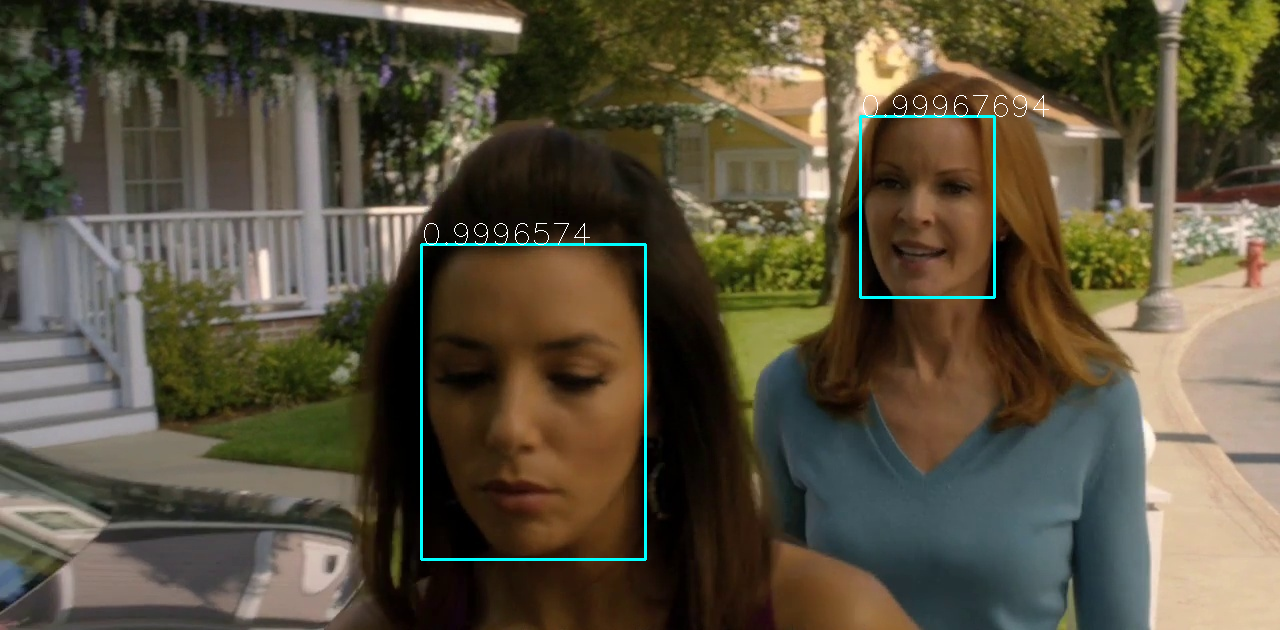

In [ ]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 1
fontColor              = (255,255,255)
thickness              = 1
lineType               = 2

text_file_chosen,sentiment_chosen,image = data_train[6] # loading file
face_all = detector_mobilenet.detect(image)
for xmin,ymin,xmax,ymax,confidence in face_all:
    cv2.rectangle(image, (int(xmin), int(ymin)),(int(xmax), int(ymax)), (255,255,0), 2)
    
    cv2.putText(image,str(confidence), (int(xmin), int(ymin)), font, fontScale,fontColor,thickness,lineType)
cv2_imshow(image)




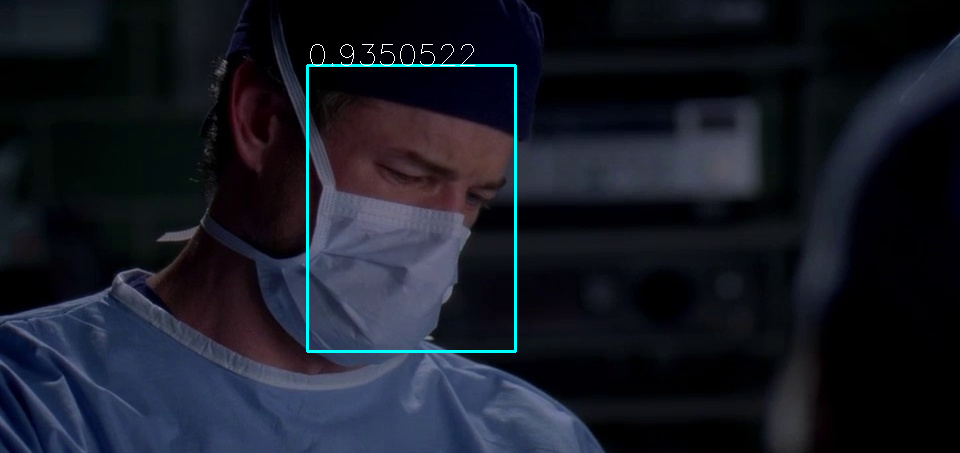

In [ ]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 1
fontColor              = (255,255,255)
thickness              = 1
lineType               = 2

text_file_chosen,sentiment_chosen,image = data_train[334] # loading file
face_all = detector_mobilenet.detect(image)
for xmin,ymin,xmax,ymax,confidence in face_all:
    cv2.rectangle(image, (int(xmin), int(ymin)),(int(xmax), int(ymax)), (255,255,0), 2)
    
    cv2.putText(image,str(confidence), (int(xmin), int(ymin)), font, fontScale,fontColor,thickness,lineType)
cv2_imshow(image)




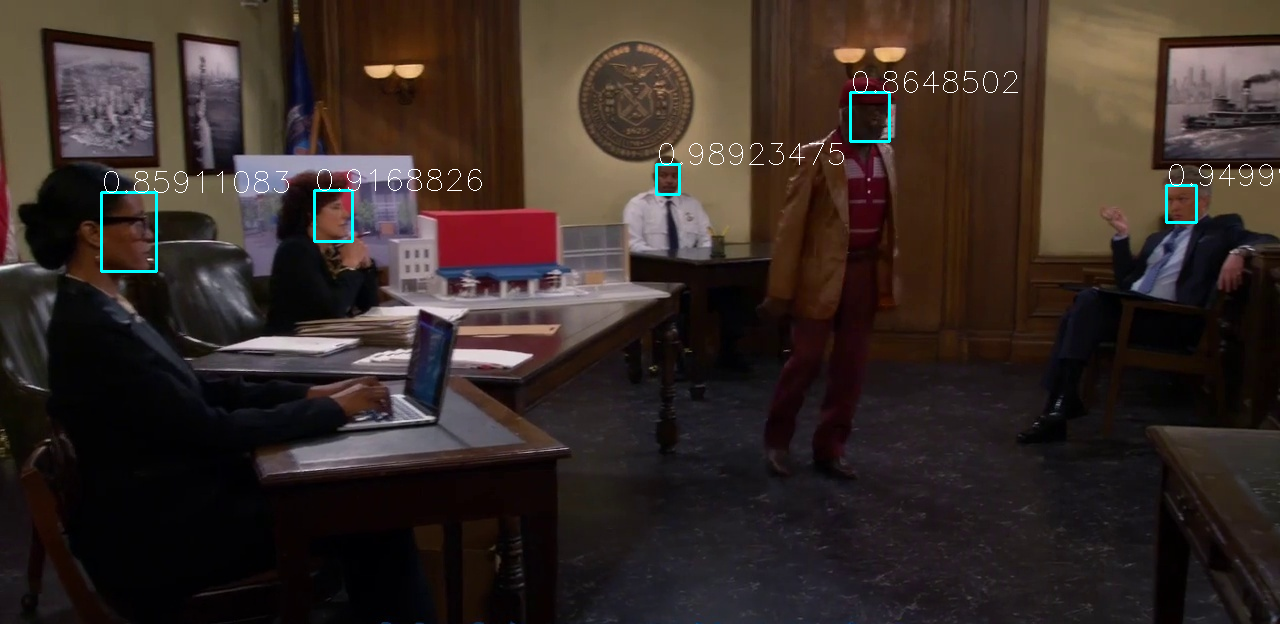

In [ ]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 1
fontColor              = (255,255,255)
thickness              = 1
lineType               = 2

text_file_chosen,sentiment_chosen,image = data_train[777] # loading file
face_all = detector_mobilenet.detect(image)
for xmin,ymin,xmax,ymax,confidence in face_all:
    cv2.rectangle(image, (int(xmin), int(ymin)),(int(xmax), int(ymax)), (255,255,0), 2)
    
    cv2.putText(image,str(confidence), (int(xmin), int(ymin)), font, fontScale,fontColor,thickness,lineType)
cv2_imshow(image)




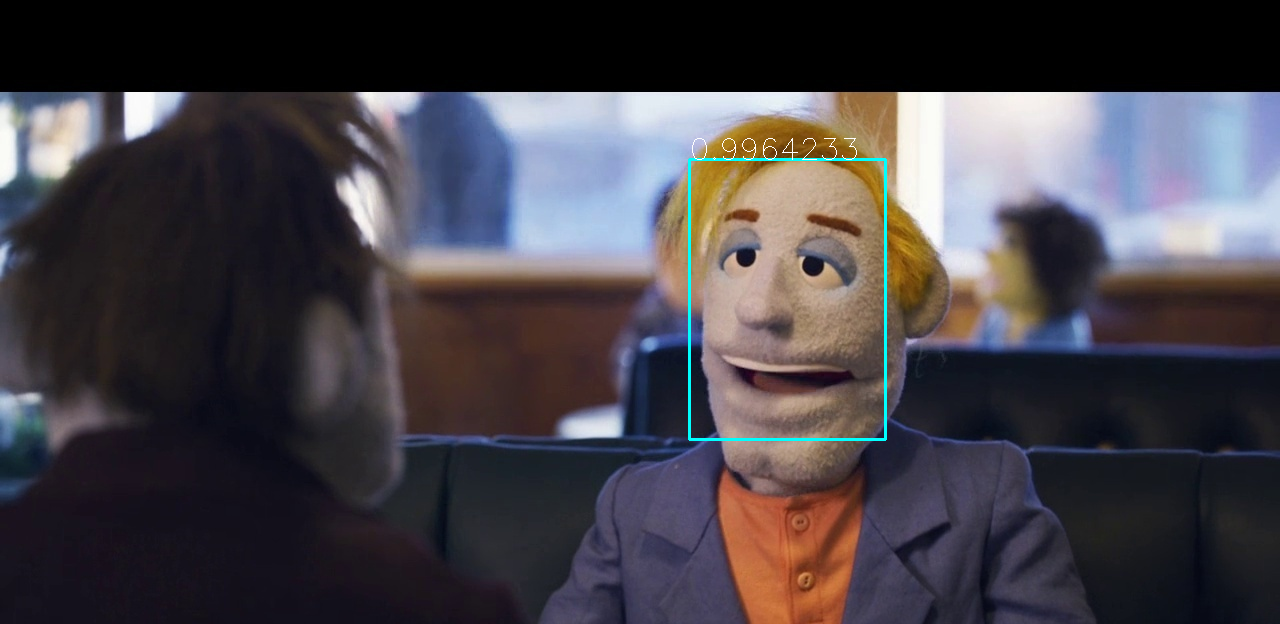

In [ ]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 1
fontColor              = (255,255,255)
thickness              = 1
lineType               = 2

text_file_chosen,sentiment_chosen,image = data_train[6666] # loading file
face_all = detector_mobilenet.detect(image)
for xmin,ymin,xmax,ymax,confidence in face_all:
    cv2.rectangle(image, (int(xmin), int(ymin)),(int(xmax), int(ymax)), (255,255,0), 2)
    
    cv2.putText(image,str(confidence), (int(xmin), int(ymin)), font, fontScale,fontColor,thickness,lineType)
cv2_imshow(image)




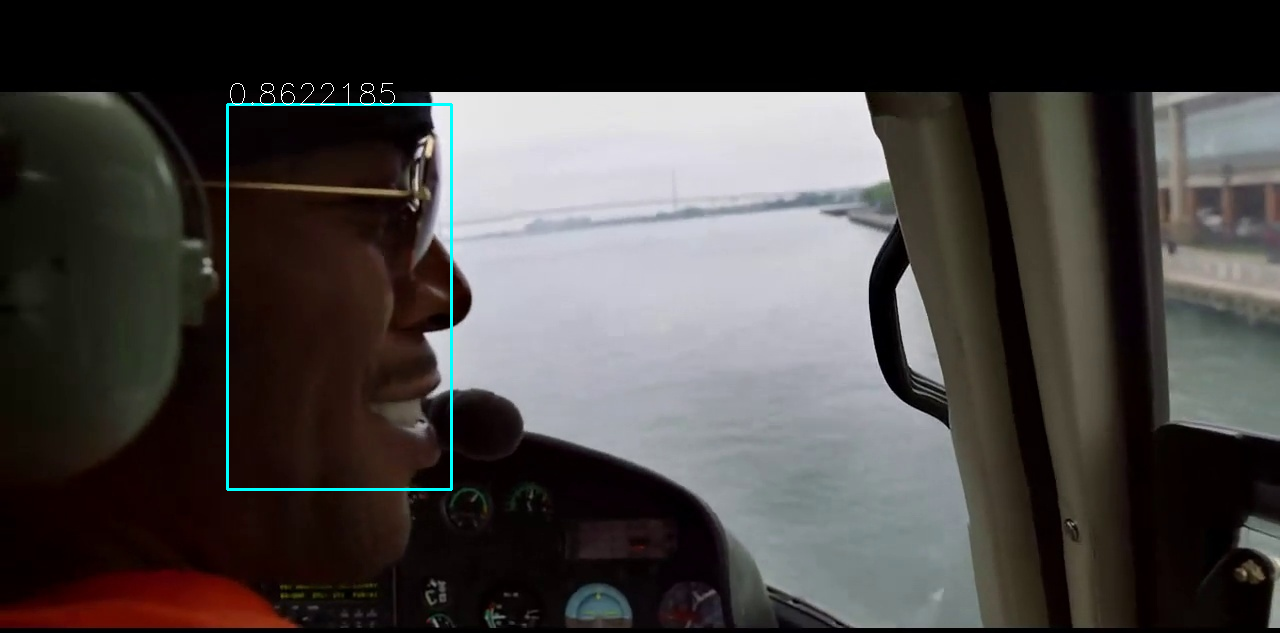

In [ ]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 1
fontColor              = (255,255,255)
thickness              = 1
lineType               = 2

text_file_chosen,sentiment_chosen,image = data_train[1378] # loading file
face_all = detector_mobilenet.detect(image)
for xmin,ymin,xmax,ymax,confidence in face_all:
    cv2.rectangle(image, (int(xmin), int(ymin)),(int(xmax), int(ymax)), (255,255,0), 2)
    
    cv2.putText(image,str(confidence), (int(xmin), int(ymin)), font, fontScale,fontColor,thickness,lineType)
cv2_imshow(image)




as we can see, it works well in different conditions, it can detect image with multiple faces, it can detect face when person face is covered, and it can even detect face of puppets! first lets extract size of some faces to have a better undrestanding when we want to reshape them

In [ ]:
X_len = []
Y_len = []
for i in tqdm(range(1000)):
  text_file_chosen,sentiment_chosen,image = data_train[i] # loading file
  face_all = detector_mobilenet.detect(image)
  for xmin,ymin,xmax,ymax,confidence in face_all:
    X_len.append(xmax-xmin)
    Y_len.append(ymax-ymin)



100%|██████████| 1000/1000 [08:36<00:00,  1.94it/s]


In [ ]:
print(f'mean of length of faces = {np.mean(X_len)}')
print(f'mean of height of faces = {np.mean(Y_len)}')

mean of length of faces = 145.19790649414062
mean of height of faces = 197.935546875


reshaping image and see result (if its good for sentiment detection or not)

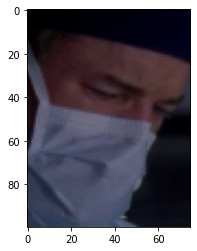

In [ ]:
text_file_chosen,sentiment_chosen,image = data_train[334] # loading file
face_all = detector_mobilenet.detect(image)
for xmin,ymin,xmax,ymax,confidence in face_all:
    image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    temp = image[int(ymin): int(ymax),int(xmin):int(xmax),:]
    image = (resize(temp,[int(100),int(75)], anti_aliasing=True)*255).astype('uint8')
plt.imshow(image)
    

In [ ]:
confidence_list = []
sentiment_list = []
image_count = []
faces_list = []
X_len = []
Y_len = []
counter = 0
for i in tqdm(range(len(data_train)), total = len(data_train), desc="extracting faces... "):
  text_file_chosen,sentiment_chosen,image = data_train[i] # loading file
  face_all = detector_mobilenet.detect(image)
  for xmin,ymin,xmax,ymax,confidence in face_all:
    if xmin < 0 :
      xmin = 0
    if ymin < 0:
      ymin = 0
    sentiment_list.append(sentiment_chosen)
    confidence_list.append(confidence)
    image_count.append(counter)
    temp = image[int(ymin): int(ymax),int(xmin):int(xmax),:]
    temp = resize(temp,[int(100),int(75)], anti_aliasing=True)
    faces_list.append(temp)
    X_len.append((xmax - xmin))
    Y_len.append((ymax - ymin))


  counter = counter + 1


  


extracting faces... : 100%|██████████| 20240/20240 [2:59:08<00:00,  1.88it/s]


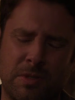

In [ ]:
cv2_imshow((255*faces_list[16004]).astype('uint8'))

saving created list for future uses

In [ ]:
import pickle
with open("/content/gdrive/MyDrive/Phase_1/face_list", "wb") as fp:   #Pickling
  pickle.dump(faces_list, fp)
with open("/content/gdrive/MyDrive/Phase_1/sentiment_list", "wb") as fp:   #Pickling
  pickle.dump(sentiment_list, fp)
with open("/content/gdrive/MyDrive/Phase_1/confidence_list", "wb") as fp:   #Pickling
  pickle.dump(confidence_list, fp)
with open("/content/gdrive/MyDrive/Phase_1/number_list", "wb") as fp:   #Pickling
  pickle.dump(image_count, fp)


In [ ]:
import pickle
with open("/content/gdrive/MyDrive/Phase_1/face_list", "rb") as fp:   # Unpickling
  faces_list = pickle.load(fp)


In [ ]:
with open("/content/gdrive/MyDrive/Phase_1/sentiment_list", "rb") as fp:   #Pickling
  sentiment_list =  pickle.load(fp)
with open("/content/gdrive/MyDrive/Phase_1/confidence_list", "rb") as fp:   #Pickling
  confidence_list = pickle.load(fp)
with open("/content/gdrive/MyDrive/Phase_1/number_list", "rb") as fp:   #Pickling
  number_list = pickle.load(fp)

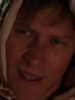

In [ ]:
cv2_imshow((255*faces_list[16000]).astype('uint8'))

now extracting images of validation and test data

In [ ]:
data_dev = MSTCDDate('/content/gdrive/MyDrive/Phase_0_images','/content/MSCTD/MSCTD_data/ende','english','dev','jpg',1)
confidence_list_v = []
sentiment_list_v = []
image_count_v = []
faces_list_v = []
counter = 0
for i in tqdm(range(len(data_dev)), total = len(data_dev), desc="extracting faces... "):
  text_file_chosen,sentiment_chosen,image = data_dev[i] # loading file
  face_all = detector_mobilenet.detect(image)
  for xmin,ymin,xmax,ymax,confidence in face_all:
    if xmin < 0 :
      xmin = 0
    if ymin < 0:
      ymin = 0
    sentiment_list_v.append(sentiment_chosen)
    confidence_list_v.append(confidence)
    image_count_v.append(counter)
    temp = image[int(ymin): int(ymax),int(xmin):int(xmax),:]
    temp = resize(temp,[int(100),int(75)], anti_aliasing=True)
    faces_list_v.append(temp)
  counter = counter + 1


  


extracting faces... : 100%|██████████| 5063/5063 [43:30<00:00,  1.94it/s]


In [ ]:
data_test = MSTCDDate('/content/gdrive/MyDrive/Phase_0_images','/content/MSCTD/MSCTD_data/ende','english','test','jpg',1)
confidence_list_t = []
sentiment_list_t = []
image_count_t = []
faces_list_t = []
counter = 0
for i in tqdm(range(len(data_test)), total = len(data_test), desc="extracting faces... "):
  text_file_chosen,sentiment_chosen,image = data_test[i] # loading file
  face_all = detector_mobilenet.detect(image)
  for xmin,ymin,xmax,ymax,confidence in face_all:
    if xmin < 0 :
      xmin = 0
    if ymin < 0:
      ymin = 0
    sentiment_list_t.append(sentiment_chosen)
    confidence_list_t.append(confidence)
    image_count_t.append(counter)
    temp = image[int(ymin): int(ymax),int(xmin):int(xmax),:]
    temp = resize(temp,[int(100),int(75)], anti_aliasing=True)
    faces_list_t.append(temp)
  counter = counter + 1


  


extracting faces... : 100%|██████████| 5067/5067 [42:34<00:00,  1.98it/s]


In [ ]:
import pickle
with open("/content/gdrive/MyDrive/Phase_1/face_list_v", "wb") as fp:   #Pickling
  pickle.dump(faces_list_v, fp)
with open("/content/gdrive/MyDrive/Phase_1/sentiment_list_v", "wb") as fp:   #Pickling
  pickle.dump(sentiment_list_v, fp)
with open("/content/gdrive/MyDrive/Phase_1/confidence_list_v", "wb") as fp:   #Pickling
  pickle.dump(confidence_list_v, fp)
with open("/content/gdrive/MyDrive/Phase_1/number_list_v", "wb") as fp:   #Pickling
  pickle.dump(image_count_v, fp)


with open("/content/gdrive/MyDrive/Phase_1/face_list_t", "wb") as fp:   #Pickling
  pickle.dump(faces_list_t, fp)
with open("/content/gdrive/MyDrive/Phase_1/sentiment_list_t", "wb") as fp:   #Pickling
  pickle.dump(sentiment_list_t, fp)
with open("/content/gdrive/MyDrive/Phase_1/confidence_list_t", "wb") as fp:   #Pickling
  pickle.dump(confidence_list_t, fp)
with open("/content/gdrive/MyDrive/Phase_1/number_list_t", "wb") as fp:   #Pickling
  pickle.dump(image_count_t, fp)


In [ ]:
import pickle
with open("/content/gdrive/MyDrive/Phase_1/face_list_v", "rb") as fp:   # Unpickling
  faces_list_v = pickle.load(fp)
with open("/content/gdrive/MyDrive/Phase_1/sentiment_list_v", "rb") as fp:   #Pickling
  sentiment_list_v =  pickle.load(fp)
with open("/content/gdrive/MyDrive/Phase_1/confidence_list_v", "rb") as fp:   #Pickling
  confidence_list_v = pickle.load(fp)
with open("/content/gdrive/MyDrive/Phase_1/number_list_v", "rb") as fp:   #Pickling
  number_list_v = pickle.load(fp)



In [ ]:
with open("/content/gdrive/MyDrive/Phase_1/face_list_t", "rb") as fp:   # Unpickling
  faces_list_t= pickle.load(fp)
with open("/content/gdrive/MyDrive/Phase_1/sentiment_list_t", "rb") as fp:   #Pickling
  sentiment_list_t =  pickle.load(fp)
with open("/content/gdrive/MyDrive/Phase_1/confidence_list_t", "rb") as fp:   #Pickling
  confidence_list_t = pickle.load(fp)
with open("/content/gdrive/MyDrive/Phase_1/number_list_t", "rb") as fp:   #Pickling
  number_list_t = pickle.load(fp)

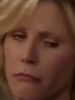

In [ ]:
cv2_imshow((255*faces_list_v[160]).astype('uint8'))

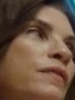

In [ ]:
cv2_imshow((255*faces_list_t[160]).astype('uint8'))

for training network, we use two different approches, first we use method described in:
"Deep-Emotion: Facial Expression Recognition Using Attentional Convolutional Network"
for this purpose, we even load kaggle dataset(https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data?select=train.csv)(if you run code it automically download necessary files so you don't need to do anything extra) and then, we use our own data to fine-tune network so it can work with our dataset.


In [ ]:
pip install -U --no-cache-dir gdown --pre


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
donwload_to_file('https://drive.google.com/u/0/uc?id=1BTPiI5rBkPLy5tLI4hwT7FiaR1pSUkZ_&export=download','test.rar','/content/data/')


Downloading...
From: https://drive.google.com/u/0/uc?id=1BTPiI5rBkPLy5tLI4hwT7FiaR1pSUkZ_&export=download
To: /content/test.rar
100%|██████████| 19.0M/19.0M [00:00<00:00, 211MB/s]


In [ ]:
!gdown --id 1eTET2nqjH5rjkXPVxyYm8HAJWfNBisBa
with ZipFile('train.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('/content/data/')


/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1eTET2nqjH5rjkXPVxyYm8HAJWfNBisBa
To: /content/train.zip
100% 76.2M/76.2M [00:00<00:00, 97.8MB/s]


for implementing Deep-emotion we use codes provided in "https://github.com/omarsayed7/Deep-Emotion" its structure with attention module that achived really good result for classifying image faces with 7 different emotions:

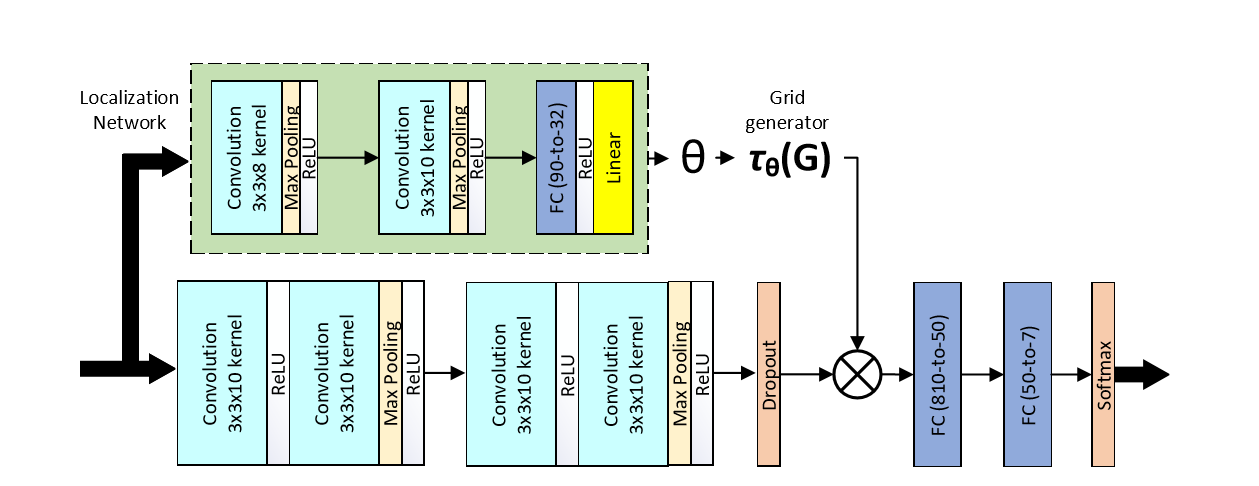

In [ ]:
# creating data
from __future__ import print_function
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm


class Generate_data():
    def __init__(self, datapath):
        """
        Generate_data class
        Two methods to be used
        1-split_test
        2-save_images
        [Note] that you have to split the public and private from fer2013 file
        """
        self.data_path = datapath

    def split_test(self, val_filename= 'val'):
        """
        Helper function to split the validation and train data from general train file.
            params:-
                data_path = path to the folder that contains the train data file
        """
        train_csv_path = self.data_path +"/"+ 'train.csv'
        train = pd.read_csv(train_csv_path)
        validation_data = pd.DataFrame(train.iloc[:3589,:])
        train_data = pd.DataFrame(train.iloc[3589:,:])
        train_data.to_csv(self.data_path+"/train.csv")
        validation_data.to_csv(self.data_path+"/"+val_filename+".csv")
        print("Done splitting the test file into validation & final test file")

    def str_to_image(self, str_img = ' '):
        '''
        Convert string pixels from the csv file into image object
            params:- take an image string
            return :- return PIL image object
        '''
        imgarray_str = str_img.split(' ')
        imgarray = np.asarray(imgarray_str,dtype=np.uint8).reshape(48,48)
        return Image.fromarray(imgarray)

    def save_images(self, datatype='train'):
        '''
        save_images is a function responsible for saving images from data files e.g(train, test) in a desired folder
            params:-
            datatype= str e.g (train, val, test)
        '''
        foldername= self.data_path+"/"+datatype
        csvfile_path= self.data_path+"/"+datatype+'.csv'
        if not os.path.exists(foldername):
            os.mkdir(foldername)

        data = pd.read_csv(csvfile_path)
        images = data['pixels'] #dataframe to series pandas
        numberofimages = images.shape[0]
        for index in tqdm(range(numberofimages)):
            img = self.str_to_image(images[index])
            img.save(os.path.join(foldername,'{}{}.jpg'.format(datatype,index)),'JPEG')
        print('Done saving {} data'.format((foldername)))

In [ ]:
generate_dataset = Generate_data('data')
generate_dataset.split_test()
generate_dataset.save_images('train')
generate_dataset.save_images('test')
generate_dataset.save_images('val')

Done splitting the test file into validation & final test file


100%|██████████| 25120/25120 [00:12<00:00, 1989.20it/s]


Done saving data/train data


100%|██████████| 7178/7178 [00:03<00:00, 2004.93it/s]


Done saving data/test data


100%|██████████| 3589/3589 [00:01<00:00, 1988.91it/s]

Done saving data/val data


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Plain_Dataset(Dataset):
    def __init__(self,csv_file,img_dir,datatype,transform):
        '''
        Pytorch Dataset class
        params:-
                 csv_file : the path of the csv file    (train, validation, test)
                 img_dir  : the directory of the images (train, validation, test)
                 datatype : string for searching along the image_dir (train, val, test)
                 transform: pytorch transformation over the data
        return :-
                 image, labels
        '''
        self.csv_file = pd.read_csv(csv_file)
        self.lables = self.csv_file['emotion']
        self.img_dir = img_dir
        self.transform = transform
        self.datatype = datatype

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = Image.open(self.img_dir+self.datatype+str(idx)+'.jpg')
        lables = np.array(self.lables[idx])
        lables = torch.from_numpy(lables).long()

        if self.transform :
            img = self.transform(img)
        return img,lables

#Helper function
def eval_data_dataloader(csv_file,img_dir,datatype,sample_number,transform= None):
    '''
    Helper function used to evaluate the Dataset class
    params:-
            csv_file : the path of the csv file    (train, validation, test)
            img_dir  : the directory of the images (train, validation, test)
            datatype : string for searching along the image_dir (train, val, test)
            sample_number : any number from the data to be shown
    '''
    if transform is None :
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
    dataset = Plain_Dataset(csv_file=csv_file,img_dir = img_dir,datatype = datatype,transform = transform)

    label = dataset.__getitem__(sample_number)[1]
    print(label)
    imgg = dataset.__getitem__(sample_number)[0]
    imgnumpy = imgg.numpy()
    imgt = imgnumpy.squeeze()
    plt.imshow(imgt)
    plt.show()

In [ ]:
traincsv_file = 'data'+'/'+ 'train.csv'
validationcsv_file = 'data'+'/'+'val.csv'
train_img_dir = 'data'+'/'+'train/'
validation_img_dir = 'data'+'/'+'val/'
batchsize = 64
transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train_dataset= Plain_Dataset(csv_file=traincsv_file, img_dir = train_img_dir, datatype = 'train', transform = transformation)
validation_dataset= Plain_Dataset(csv_file=validationcsv_file, img_dir = validation_img_dir, datatype = 'val', transform = transformation)
train_loader= DataLoader(train_dataset,batch_size=batchsize,shuffle = True,)
val_loader=   DataLoader(validation_dataset,batch_size=batchsize,shuffle = True)

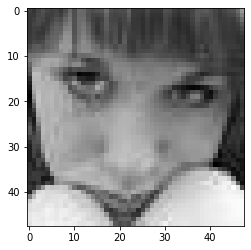

In [ ]:
# plotting a data from new dataset
img,label = train_dataset[20]
plt.imshow(np.reshape(img,(48,48,)),cmap='gray')

In [ ]:
class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self,input):
        out = self.stn(input)

        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [ ]:
net = Deep_Emotion()
net.to(device)

Deep_Emotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplac

In [ ]:
def train_model_manual(model, criterion, optimizer,scheduler,val_beark,data_loader_train,data_loader_val, num_epochs=25):
  """
  function for train our model! in this function we use dataloader directly. so we only can use it for our CIFAR10 dataset with our input name. compared to previous function, 
  we use augmented dataset here
  inputs: 
      model: input model 
      criterion: desired loss function
      optimizer: our optimizer(!)
      scheduler: for changing learning rate after sum epochs
      num_epochs: number of epoches
      val_beark: threshold for early stopping, if after "val_beark" steps our model don't get better, we end procces
  output:
      model: our trained model!


  """
  train_acc = []
  train_loss = []
  test_acc = []
  test_loss = []
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 100000000000
  counter_val_beark = 0
  for epoch in range(num_epochs):
    ### Training
    model.train()
    loss_train = 0
    acc_train = 0
    counter = 1
    for batch,label in tqdm(data_loader_train, total=len(data_loader_train), desc="training... "):
      # 1. Forward pass
      batch = batch.to(device)
      label = label.to(device)
      outputs = model(batch) # model outputs raw logits 
      _, preds = torch.max(outputs, 1)

      # print(y_logits)
      # 2. Calculate loss and accuracy
      counter = counter + 1
      loss = criterion(outputs, label)
      acc_train += torch.sum(preds == label.data)
      loss_train = loss_train + loss
      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()
    loss_train = loss_train/counter
    acc_train = acc_train/len(data_loader_train)
    train_acc.append(acc_train)
    train_loss.append(loss_train)
    scheduler.step()
    ### Testing
    loss_test = 0
    acc_test = 0
    counter = 1
    model.eval()
    with torch.inference_mode():
      for batch,label in tqdm(data_loader_val, total=len(data_loader_val), desc="Validating... "):
      # 1. Forward pass
        batch = batch.to(device)
        label = label.to(device)
        output = model(batch) # model outputs raw logits 
        _, preds = torch.max(output, 1)
        loss_test= criterion(output, label.data)
        acc_test += torch.sum(preds == label.data)
      loss_test = loss_test/counter
      acc_test = acc_test/len(data_loader_val)
      test_loss.append(loss_test)
      test_acc.append(acc_test)
    if acc_test > best_acc:
                best_acc = acc_test
                best_model_wts = copy.deepcopy(model.state_dict())
    if loss_test <= best_loss:
                best_loss = loss_test
                counter_val_beark = 0
    if loss_test > best_loss:
                counter_val_beark = counter_val_beark + 1
                if (counter_val_beark > val_beark):
                  print(f"early stopping happend!")
                  break;

    # Print out what's happening
    if epoch % 1 == 0:
      print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {acc_test:.2f}%") 
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model,best_loss,best_acc


In [ ]:
criterion = nn.CrossEntropyLoss()
epochs = 100
lr = 0.005
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(net.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=150, gamma=0.5)

net_trained,best_loss,best_acc = train_model_manual(net, criterion, optimizer_conv,exp_lr_scheduler,50,train_loader,val_loader,num_epochs=5)

training... :   0%|          | 0/393 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
Validating... : 100%|██████████| 57/57 [00:03<00:00, 15.07it/s]


Epoch: 0 | Loss: 1.65819, Acc: 21.36% | Test Loss: 1.04690, Test Acc: 23.65%


Validating... : 100%|██████████| 57/57 [00:03<00:00, 15.59it/s]


Epoch: 1 | Loss: 1.52085, Acc: 25.76% | Test Loss: 1.72596, Test Acc: 25.60%


Validating... : 100%|██████████| 57/57 [00:03<00:00, 15.79it/s]


Epoch: 2 | Loss: 1.46986, Acc: 27.20% | Test Loss: 1.14317, Test Acc: 26.39%


Validating... : 100%|██████████| 57/57 [00:03<00:00, 15.49it/s]


Epoch: 3 | Loss: 1.43146, Acc: 28.36% | Test Loss: 1.19340, Test Acc: 26.88%


Validating... : 100%|██████████| 57/57 [00:03<00:00, 15.41it/s]

Epoch: 4 | Loss: 1.41071, Acc: 28.90% | Test Loss: 1.64468, Test Acc: 27.11%
Training complete in 5m 17s
Best val Acc: 27.105263


In [ ]:
def Train(epochs,train_loader,val_loader,criterion,optmizer,device):
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)

        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/len(train_dataset)
        train_acc = train_correct.double() / len(train_dataset)
        validation_loss =  validation_loss / len(validation_dataset)
        val_acc = val_correct.double() / len(validation_dataset)
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))

    torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    print("===================================Training Finished===================================")
    return net



In [ ]:
def Train_size(epochs,train_loader,val_loader,criterion,optmizer,device,len_train,len_val):
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)

        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/len_train
        train_acc = train_correct.double() / len_train
        validation_loss =  validation_loss / len_val
        val_acc = val_correct.double() / len_val
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))

    torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    print("===================================Training Finished===================================")
    return net



In [ ]:
epochs = 100
lr = 0.005
net = Deep_Emotion()
net.to(device)
print("Model archticture: ", net)
criterion= nn.CrossEntropyLoss()
optmizer= optim.Adam(net.parameters(),lr= lr)
net = Train(100, train_loader, val_loader, criterion, optmizer, device)

Model archticture:  Deep_Emotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch: 1 	Training Loss: 0.02635848 	Validation Loss 0.02564189 	Training Acuuarcy 32.950% 	Validation Acuuarcy 36.473%
Epoch: 2 	Training Loss: 0.02433341 	Validation Loss 0.02399597 	Training Acuuarcy 38.758% 	Validation Acuuarcy 40.847%
Epoch: 3 	Training Loss: 0.02309834 	Validation Loss 0.02329033 	Training Acuuarcy 42.492% 	Validation Acuuarcy 43.048%
Epoch: 4 	Training Loss: 0.02241088 	Validation Loss 0.02324362 	Training Acuuarcy 44.192% 	Validation Acuuarcy 43.271%
Epoch: 5 	Training Loss: 0.02200803 	Validation Loss 0.02244324 	Training Acuuarcy 45.322% 	Validation Acuuarcy 44.971%
Epoch: 6 	Training Loss: 0.02165625 	Validation Loss 0.02232782 	Training Acuuarcy 46.338% 	Validation Acuuarcy 44.804%
Epoch: 7 	Training Loss: 0.02146014 	Validation Loss 0.02270357 	Training Acuuarcy 46.907% 	Validation Acuuarcy 45.417%
Epoch: 8 	Training Loss: 0.02146667 	Validation Loss 0.02221623 	Training Acuuarcy 46.971% 	Validation Acuuarcy 46.057%
Epoch: 9 	Training Loss: 0.02114576 	Val

In [ ]:
torch.save(net.state_dict(), '/content/gdrive/MyDrive/Phase_1_models/net1')

In [ ]:
net = Deep_Emotion()
net.to(device)
net.load_state_dict(torch.load('/content/gdrive/MyDrive/Phase_1_models/net1'))
net.eval()
val_correct = 0
for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)
val_acc = val_correct.double() / len(validation_dataset)
print(val_acc)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor(0.4868, device='cuda:0', dtype=torch.float64)


In [ ]:
net = Deep_Emotion()
net.to(device)
net.load_state_dict(torch.load('/content/gdrive/MyDrive/Phase_1_models/net1'))
net.eval()
net.fc2 = nn.Linear(50, 3)
print(net)

Deep_Emotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=3, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplac

In [ ]:
class Face_Dataset(Dataset):
    def __init__(self,face,labels,transform):
        '''
        Pytorch Dataset class
        params:-
                 face : list of faces that we saved
                 labels: list of labels
                 transform: pytorch transformation over the data
        return :-
                 image, labels
        '''
        self.face = face
        self.lables = labels
        self.transform = transform

    def __len__(self):
        return len(self.lables)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.face[idx]
        lables = self.lables[idx]

        if self.transform :
            img = self.transform(img)
            img = img.float()

        
        return img,lables

In [ ]:
batch_size = 64
transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,)),transforms.Grayscale(),transforms.Resize((48,48))])
train_dataset_face= Face_Dataset(face = faces_list ,labels = sentiment_list,  transform = transformation)
val_dataset_face = Face_Dataset(face = faces_list_v ,labels = sentiment_list_v,  transform = transformation)
train_loader_face= DataLoader(train_dataset_face,batch_size=batch_size,shuffle = True,)
val_loader_face=   DataLoader(val_dataset_face,batch_size=batch_size,shuffle = False)

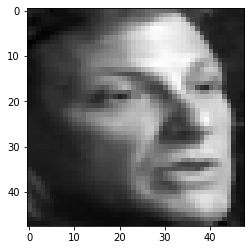

In [ ]:
image_sample,_ = train_dataset_face[0]
plt.imshow(np.reshape(image_sample,(48,48)),cmap = 'gray')

In [ ]:
epochs = 100
net = net.to(device)
lr = 0.005
batchsize = 64
print("Model archticture: ", net)
criterion= nn.CrossEntropyLoss()
optmizer= optim.Adam(net.parameters(),lr= lr)
net_trained = Train_size(100, train_loader_face, val_loader_face, criterion, optmizer, device,len(train_dataset_face),len(val_dataset_face))

Model archticture:  Deep_Emotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=3, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [ ]:
torch.save(net_trained.state_dict(), '/content/gdrive/MyDrive/Phase_1_models/net_trained')

In [ ]:
epochs = 100
net = Deep_Emotion()
net = net.to(device)
lr = 0.005
batchsize = 64
print("Model archticture: ", net)
criterion= nn.CrossEntropyLoss()
optmizer= optim.Adam(net.parameters(),lr= lr)
net_trained = Train_size(10, train_loader_face, val_loader_face, criterion, optmizer, device,len(train_dataset_face),len(val_dataset_face))

Model archticture:  Deep_Emotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


as we can see, its random!
but in previous part we showed that this structure can really work.
lets try to fine tune a deep network on reults:

In [ ]:
model_resnet = torchvision.models.resnet50(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 3) # we have 10 output class

model_resnet = model_resnet.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
class Face_Dataset(Dataset):
    def __init__(self,face,labels,transform):
        '''
        Pytorch Dataset class
        params:-
                 face : list of faces that we saved
                 labels: list of labels
                 transform: pytorch transformation over the data
        return :-
                 image, labels
        '''
        self.face = face
        self.lables = labels
        self.transform = transform

    def __len__(self):
        return len(self.lables)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.face[idx]
        img = img[:,:,[2,1,0]]
        lables = self.lables[idx]

        if self.transform :
            img = self.transform(img)
            img = img.float()

        
        return img,lables

In [ ]:
batch_size = 64
transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train_dataset_face= Face_Dataset(face = faces_list ,labels = sentiment_list,  transform = transformation)
val_dataset_face = Face_Dataset(face = faces_list_v ,labels = sentiment_list_v,  transform = transformation)
train_loader_face= DataLoader(train_dataset_face,batch_size=batch_size,shuffle = True,)
val_loader_face=   DataLoader(val_dataset_face,batch_size=batch_size,shuffle = False)

test_dataset_face = Face_Dataset(face = faces_list_t ,labels = sentiment_list_t,  transform = transformation)
test_loader_face= DataLoader(test_dataset_face,batch_size=64,shuffle = False,)

In [ ]:
def train_model_manual(model, criterion, optimizer,scheduler,val_beark,data_loader_train,data_loader_val,len_train,len_val, num_epochs=25):
  """
  function for train our model! in this function we use dataloader directly. so we only can use it for our CIFAR10 dataset with our input name. compared to previous function, 
  we use augmented dataset here
  inputs: 
      model: input model 
      criterion: desired loss function
      optimizer: our optimizer(!)
      scheduler: for changing learning rate after sum epochs
      num_epochs: number of epoches
      val_beark: threshold for early stopping, if after "val_beark" steps our model don't get better, we end procces
  output:
      model: our trained model!


  """
  train_acc = []
  train_loss = []
  test_acc = []
  test_loss = []
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 100000000000
  counter_val_beark = 0
  for epoch in range(num_epochs):
    ### Training
    model.train()
    loss_train = 0
    acc_train = 0
    counter = 1
    for batch,label in tqdm(data_loader_train, total=len(data_loader_train), desc="training... "):
      # 1. Forward pass
      batch = batch.to(device)
      label = label.to(device)
      outputs = model(batch) # model outputs raw logits 
      _, preds = torch.max(outputs, 1)

      # print(y_logits)
      # 2. Calculate loss and accuracy
      counter = counter + 1
      loss = criterion(outputs, label)
      acc_train += torch.sum(preds == label.data)
      loss_train = loss_train + loss
      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()
    loss_train = loss_train/len_train
    acc_train = acc_train/len_train
    train_acc.append(acc_train)
    train_loss.append(loss_train)
    scheduler.step()
    ### Testing
    loss_test = 0
    acc_test = 0
    counter = 1
    model.eval()
    with torch.inference_mode():
      for batch,label in tqdm(data_loader_val, total=len(data_loader_val), desc="Validating... "):
      # 1. Forward pass
        batch = batch.to(device)
        label = label.to(device)
        output = model(batch) # model outputs raw logits 
        _, preds = torch.max(output, 1)
        loss_test= criterion(output, label.data)
        acc_test += torch.sum(preds == label.data)
      loss_test = loss_test/len_val
      acc_test = acc_test/len_val
      test_loss.append(loss_test)
      test_acc.append(acc_test)
    if acc_test > best_acc:
                best_acc = acc_test
                best_model_wts = copy.deepcopy(model.state_dict())
    if loss_test <= best_loss:
                best_loss = loss_test
                counter_val_beark = 0
    if loss_test > best_loss:
                counter_val_beark = counter_val_beark + 1
                if (counter_val_beark > val_beark):
                  print(f"early stopping happend!")
                  break;

    # Print out what's happening
    if epoch % 1 == 0:
      print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {acc_test:.2f}%") 
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model,best_loss,best_acc


In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_resnet.parameters(), lr=0.005)
# Decay LR by a factor of 0.5 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=100, gamma=0.5)

model_resnet = model_resnet.to(device)
model_resnet_trained,best_loss,best_acc = train_model_manual(model_resnet, criterion, optimizer_conv,exp_lr_scheduler,20,train_loader_face,val_loader_face,len(train_dataset_face),len(val_dataset_face),num_epochs=100)

Validating... : 100%|██████████| 106/106 [00:04<00:00, 25.26it/s]


Epoch: 0 | Loss: 0.01785, Acc: 0.37% | Test Loss: 0.00016, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 25.10it/s]


Epoch: 1 | Loss: 0.01706, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.97it/s]


Epoch: 2 | Loss: 0.01704, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.91it/s]


Epoch: 3 | Loss: 0.01703, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.99it/s]


Epoch: 4 | Loss: 0.01704, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.94it/s]


Epoch: 5 | Loss: 0.01702, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.97it/s]


Epoch: 6 | Loss: 0.01701, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.94it/s]


Epoch: 7 | Loss: 0.01705, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.95it/s]


Epoch: 8 | Loss: 0.01703, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.94it/s]


Epoch: 9 | Loss: 0.01704, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 25.05it/s]


Epoch: 10 | Loss: 0.01706, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.96it/s]


Epoch: 11 | Loss: 0.01706, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.96it/s]


Epoch: 12 | Loss: 0.01702, Acc: 0.39% | Test Loss: 0.00016, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.96it/s]


Epoch: 13 | Loss: 0.01702, Acc: 0.39% | Test Loss: 0.00018, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.94it/s]


Epoch: 14 | Loss: 0.01700, Acc: 0.39% | Test Loss: 0.00018, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.88it/s]


Epoch: 15 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00018, Test Acc: 0.27%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.92it/s]


Epoch: 16 | Loss: 0.01706, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.78it/s]


Epoch: 17 | Loss: 0.01701, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.94it/s]


Epoch: 18 | Loss: 0.01701, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.96it/s]


Epoch: 19 | Loss: 0.01701, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 24.80it/s]


Epoch: 20 | Loss: 0.01701, Acc: 0.39% | Test Loss: 0.00016, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 25.62it/s]


early stopping happend!
Training complete in 30m 43s
Best val Acc: 0.366110


In [ ]:
torch.save(model_resnet_trained.state_dict(), '/content/gdrive/MyDrive/Phase_1_models/resnet_trained')

In [ ]:
model_resnet_trained = torchvision.models.resnet50(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet_trained.fc.in_features
model_resnet_trained.fc = nn.Linear(num_ftrs, 3) # we have 10 output class

model_resnet_trained = model_resnet_trained.to(device)
if device == 'cpu':
  model_resnet_trained.load_state_dict(torch.load('/content/gdrive/MyDrive/Phase_1_models/resnet_trained',map_location=torch.device('cpu')))
else:
  model_resnet_trained.load_state_dict(torch.load('/content/gdrive/MyDrive/Phase_1_models/resnet_trained'))




/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


testing model on test data

In [ ]:
model_resnet_trained.eval()
acc_test = 0
with torch.inference_mode():
  for batch,label in tqdm(test_loader_face, total=len(test_loader_face), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_resnet_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on test data = {acc_test/len(test_dataset_face)}')

Testing... : 100%|██████████| 108/108 [00:04<00:00, 21.75it/s]



accuracy on test data = 0.39542293548583984


manual resnet50

In [ ]:
batch_size = 64
transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train_dataset_face= Face_Dataset(face = faces_list ,labels = sentiment_list,  transform = transformation)
val_dataset_face = Face_Dataset(face = faces_list_v ,labels = sentiment_list_v,  transform = transformation)
train_loader_face= DataLoader(train_dataset_face,batch_size=batch_size,shuffle = True,)
val_loader_face=   DataLoader(val_dataset_face,batch_size=batch_size,shuffle = False)

test_dataset_face = Face_Dataset(face = faces_list_t ,labels = sentiment_list_t,  transform = transformation)
test_loader_face= DataLoader(test_dataset_face,batch_size=64,shuffle = False,)

In [ ]:
import torch
import torch.nn as  nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
model_res = ResNet50(3)

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_res.parameters(), lr=0.001)
# Decay LR by a factor of 0.5 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=100, gamma=0.5)

model_res = model_res.to(device)
model_res_trained,best_loss,best_acc = train_model_manual(model_res, criterion, optimizer_conv,exp_lr_scheduler,20,train_loader_face,val_loader_face,len(train_dataset_face),len(val_dataset_face),num_epochs=5)

Validating... : 100%|██████████| 106/106 [00:04<00:00, 22.83it/s]


Epoch: 0 | Loss: 0.01794, Acc: 0.37% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 22.85it/s]


Epoch: 1 | Loss: 0.01736, Acc: 0.38% | Test Loss: 0.00016, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 22.90it/s]


Epoch: 2 | Loss: 0.01737, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 22.86it/s]


Epoch: 3 | Loss: 0.01733, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:04<00:00, 22.87it/s]


Epoch: 4 | Loss: 0.01738, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.37%
Training complete in 6m 18s
Best val Acc: 0.366405


In [ ]:
torch.save(model_res_trained.state_dict(), '/content/gdrive/MyDrive/Phase_1_models/resnet_trained_manual')

In [ ]:
model_res_trained.eval()
acc_test = 0
with torch.inference_mode():
  for batch,label in tqdm(test_loader_face, total=len(test_loader_face), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_res_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on test data = {acc_test/len(test_dataset_face)}')

Testing... : 100%|██████████| 108/108 [00:04<00:00, 22.79it/s]




accuracy on test data = 0.35486674308776855


now we use just a simple cnn

In [ ]:
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(21120, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
conv_simple = ConvNeuralNet(3)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(conv_simple.parameters(), lr=0.0001)
# Decay LR by a factor of 0.5 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=100, gamma=0.5)

conv_simple = conv_simple.to(device)
conv_simple_trained,best_loss,best_acc = train_model_manual(conv_simple, criterion, optimizer_conv,exp_lr_scheduler,20,train_loader_face,val_loader_face,len(train_dataset_face),len(val_dataset_face),num_epochs=100)

Validating... : 100%|██████████| 106/106 [00:01<00:00, 70.26it/s]


Epoch: 0 | Loss: 0.01711, Acc: 0.35% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.06it/s]


Epoch: 1 | Loss: 0.01709, Acc: 0.36% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.05it/s]


Epoch: 2 | Loss: 0.01707, Acc: 0.37% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 70.53it/s]


Epoch: 3 | Loss: 0.01706, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 70.68it/s]


Epoch: 4 | Loss: 0.01706, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 70.25it/s]


Epoch: 5 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 68.48it/s]


Epoch: 6 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 70.02it/s]


Epoch: 7 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 68.16it/s]


Epoch: 8 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 66.95it/s]


Epoch: 9 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 67.47it/s]


Epoch: 10 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 69.61it/s]


Epoch: 11 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 69.66it/s]


Epoch: 12 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 70.60it/s]


Epoch: 13 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 69.84it/s]


Epoch: 14 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 68.41it/s]


Epoch: 15 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 66.91it/s]


Epoch: 16 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 65.21it/s]


Epoch: 17 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.49it/s]


Epoch: 18 | Loss: 0.01705, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 74.52it/s]


Epoch: 19 | Loss: 0.01704, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.10it/s]


Epoch: 20 | Loss: 0.01704, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.71it/s]


Epoch: 21 | Loss: 0.01704, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 71.73it/s]


Epoch: 22 | Loss: 0.01704, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.15it/s]


Epoch: 23 | Loss: 0.01704, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.45it/s]


early stopping happend!
Training complete in 5m 45s
Best val Acc: 0.371581


In [ ]:
conv_simple = ConvNeuralNet(3)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(conv_simple.parameters(), lr=0.01)
# Decay LR by a factor of 0.5 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=100, gamma=0.5)

conv_simple = conv_simple.to(device)
conv_simple_trained,best_loss,best_acc = train_model_manual(conv_simple, criterion, optimizer_conv,exp_lr_scheduler,50,train_loader_face,val_loader_face,len(train_dataset_face),len(val_dataset_face),num_epochs=100)

Validating... : 100%|██████████| 106/106 [00:01<00:00, 70.65it/s]


Epoch: 0 | Loss: 0.01706, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:02<00:00, 41.90it/s]


Epoch: 1 | Loss: 0.01704, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:03<00:00, 34.96it/s]


Epoch: 2 | Loss: 0.01703, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:02<00:00, 40.36it/s]


Epoch: 3 | Loss: 0.01702, Acc: 0.39% | Test Loss: 0.00016, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.27it/s]


Epoch: 4 | Loss: 0.01701, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.84it/s]


Epoch: 5 | Loss: 0.01699, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.91it/s]


Epoch: 6 | Loss: 0.01698, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.93it/s]


Epoch: 7 | Loss: 0.01697, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 74.69it/s]


Epoch: 8 | Loss: 0.01696, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.47it/s]


Epoch: 9 | Loss: 0.01695, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.34it/s]


Epoch: 10 | Loss: 0.01693, Acc: 0.40% | Test Loss: 0.00016, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 74.20it/s]


Epoch: 11 | Loss: 0.01692, Acc: 0.39% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.31it/s]


Epoch: 12 | Loss: 0.01691, Acc: 0.40% | Test Loss: 0.00016, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 71.23it/s]


Epoch: 13 | Loss: 0.01689, Acc: 0.40% | Test Loss: 0.00016, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.26it/s]


Epoch: 14 | Loss: 0.01688, Acc: 0.40% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 78.20it/s]


Epoch: 15 | Loss: 0.01685, Acc: 0.40% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 75.41it/s]


Epoch: 16 | Loss: 0.01684, Acc: 0.41% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.38it/s]


Epoch: 17 | Loss: 0.01681, Acc: 0.41% | Test Loss: 0.00016, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 74.68it/s]


Epoch: 18 | Loss: 0.01679, Acc: 0.41% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 75.50it/s]


Epoch: 19 | Loss: 0.01677, Acc: 0.41% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 76.01it/s]


Epoch: 20 | Loss: 0.01674, Acc: 0.41% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 75.09it/s]


Epoch: 21 | Loss: 0.01671, Acc: 0.42% | Test Loss: 0.00017, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 75.48it/s]


Epoch: 22 | Loss: 0.01667, Acc: 0.42% | Test Loss: 0.00016, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 71.31it/s]


Epoch: 23 | Loss: 0.01663, Acc: 0.42% | Test Loss: 0.00016, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.11it/s]


Epoch: 24 | Loss: 0.01659, Acc: 0.43% | Test Loss: 0.00017, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.30it/s]


Epoch: 25 | Loss: 0.01653, Acc: 0.44% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.96it/s]


Epoch: 26 | Loss: 0.01645, Acc: 0.44% | Test Loss: 0.00018, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 74.27it/s]


Epoch: 27 | Loss: 0.01637, Acc: 0.45% | Test Loss: 0.00017, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 75.14it/s]


Epoch: 28 | Loss: 0.01627, Acc: 0.45% | Test Loss: 0.00019, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.43it/s]


Epoch: 29 | Loss: 0.01615, Acc: 0.46% | Test Loss: 0.00018, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 76.56it/s]


Epoch: 30 | Loss: 0.01600, Acc: 0.47% | Test Loss: 0.00018, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 71.16it/s]


Epoch: 31 | Loss: 0.01582, Acc: 0.48% | Test Loss: 0.00017, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 74.19it/s]


Epoch: 32 | Loss: 0.01561, Acc: 0.49% | Test Loss: 0.00018, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.81it/s]


Epoch: 33 | Loss: 0.01532, Acc: 0.51% | Test Loss: 0.00019, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.86it/s]


Epoch: 34 | Loss: 0.01502, Acc: 0.52% | Test Loss: 0.00019, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 75.81it/s]


Epoch: 35 | Loss: 0.01466, Acc: 0.54% | Test Loss: 0.00019, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 71.56it/s]


Epoch: 36 | Loss: 0.01424, Acc: 0.56% | Test Loss: 0.00019, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 74.13it/s]


Epoch: 37 | Loss: 0.01372, Acc: 0.58% | Test Loss: 0.00021, Test Acc: 0.36%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.53it/s]


Epoch: 38 | Loss: 0.01325, Acc: 0.60% | Test Loss: 0.00021, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 74.29it/s]


Epoch: 39 | Loss: 0.01256, Acc: 0.63% | Test Loss: 0.00022, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 71.20it/s]


Epoch: 40 | Loss: 0.01206, Acc: 0.65% | Test Loss: 0.00024, Test Acc: 0.33%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.93it/s]


Epoch: 41 | Loss: 0.01144, Acc: 0.67% | Test Loss: 0.00026, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.14it/s]


Epoch: 42 | Loss: 0.01076, Acc: 0.70% | Test Loss: 0.00029, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 70.37it/s]


Epoch: 43 | Loss: 0.01024, Acc: 0.71% | Test Loss: 0.00033, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.48it/s]


Epoch: 44 | Loss: 0.00952, Acc: 0.74% | Test Loss: 0.00037, Test Acc: 0.33%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 75.57it/s]


Epoch: 45 | Loss: 0.00904, Acc: 0.75% | Test Loss: 0.00037, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.67it/s]


Epoch: 46 | Loss: 0.00838, Acc: 0.78% | Test Loss: 0.00035, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.65it/s]


Epoch: 47 | Loss: 0.00789, Acc: 0.80% | Test Loss: 0.00041, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.63it/s]


Epoch: 48 | Loss: 0.00772, Acc: 0.81% | Test Loss: 0.00037, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 74.31it/s]


Epoch: 49 | Loss: 0.00692, Acc: 0.83% | Test Loss: 0.00042, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 76.17it/s]


Epoch: 50 | Loss: 0.00662, Acc: 0.84% | Test Loss: 0.00050, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 74.64it/s]


Epoch: 51 | Loss: 0.00625, Acc: 0.85% | Test Loss: 0.00046, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.24it/s]


Epoch: 52 | Loss: 0.00590, Acc: 0.86% | Test Loss: 0.00045, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 74.56it/s]


Epoch: 53 | Loss: 0.00563, Acc: 0.87% | Test Loss: 0.00060, Test Acc: 0.33%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.83it/s]


Epoch: 54 | Loss: 0.00525, Acc: 0.89% | Test Loss: 0.00053, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 74.40it/s]


Epoch: 55 | Loss: 0.00485, Acc: 0.90% | Test Loss: 0.00060, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.12it/s]


Epoch: 56 | Loss: 0.00475, Acc: 0.90% | Test Loss: 0.00054, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 71.04it/s]


Epoch: 57 | Loss: 0.00441, Acc: 0.91% | Test Loss: 0.00061, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 70.12it/s]


Epoch: 58 | Loss: 0.00417, Acc: 0.92% | Test Loss: 0.00053, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.04it/s]


Epoch: 59 | Loss: 0.00408, Acc: 0.92% | Test Loss: 0.00062, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.19it/s]


Epoch: 60 | Loss: 0.00390, Acc: 0.93% | Test Loss: 0.00060, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.48it/s]


Epoch: 61 | Loss: 0.00355, Acc: 0.94% | Test Loss: 0.00070, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 70.90it/s]


Epoch: 62 | Loss: 0.00352, Acc: 0.94% | Test Loss: 0.00071, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 71.85it/s]


Epoch: 63 | Loss: 0.00322, Acc: 0.95% | Test Loss: 0.00064, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.73it/s]


Epoch: 64 | Loss: 0.00315, Acc: 0.95% | Test Loss: 0.00068, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 70.28it/s]


Epoch: 65 | Loss: 0.00308, Acc: 0.95% | Test Loss: 0.00070, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 71.69it/s]


Epoch: 66 | Loss: 0.00286, Acc: 0.96% | Test Loss: 0.00070, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 72.46it/s]


Epoch: 67 | Loss: 0.00285, Acc: 0.96% | Test Loss: 0.00068, Test Acc: 0.34%


Validating... : 100%|██████████| 106/106 [00:01<00:00, 73.63it/s]


early stopping happend!
Training complete in 15m 51s
Best val Acc: 0.371137


In [ ]:
conv_simple.eval()
acc_test = 0
with torch.inference_mode():
  for batch,label in tqdm(test_loader_face, total=len(test_loader_face), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = conv_simple(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on test data = {acc_test/len(test_dataset_face)}')

Testing... : 100%|██████████| 108/108 [00:02<00:00, 37.50it/s]



accuracy on test data = 0.35472190380096436


as we can see, all of models are near random! but lets try to see if we combine all faces of each image, can we improve accuracy or not. we choose resnet model because it works with 3 channel images(colored image) and in next parts that we need to apply image augmentation, because we have color augmentation its better to use this model and also it got us best test value

In [ ]:
def softmax_manual(X,t):
  """
  manual function for implementing softmax
  input:
    X:input, each coloumn is seperate data
    t:temperature value
  output:
    y
  """
  
  _,m = X.size()
  m = int(m)
  x_max = (torch.max(X,axis = 1)).values
  X = (X.T - x_max).T #adding value doesn't have effect on softmax output but it helpd to stablaize our values!(because it is ways easier to comput exp(-145) compare to exp(145)! one is near zero and one is very big number that we can't store in memory)
  exp_X = torch.exp(X/t)
  exp_X_sum = torch.sum(exp_X,axis = 1)
  exp_X_sum_rep = exp_X_sum.repeat(m,1).T
  y = exp_X/exp_X_sum_rep
  return y

In [ ]:
img,sentiment  = train_dataset_face[10]
img = img.to(device)
img = img.unsqueeze(0)

out_l = model_resnet_trained(img)
out = softmax_manual(out_l,0.1)
print(f"output before softmax{out_l}")
print(f"output after softmax{out}")
print(f"sentiment = {sentiment}")

output before softmaxtensor([[0.4670, 0.0205, 0.0288]], device='cuda:0', grad_fn=<AddmmBackward0>)
output after softmaxtensor([[0.9766, 0.0112, 0.0122]], device='cuda:0', grad_fn=<DivBackward0>)
sentiment = 0


In [ ]:
img,sentiment  = train_dataset_face[100]
img = img.to(device)
img = img.unsqueeze(0)
out_l = model_resnet_trained(img)
out = softmax_manual(out_l,0.1)
print(f"output before softmax{out_l}")
print(f"output after softmax{out}")
print(f"sentiment = {sentiment}")

output before softmaxtensor([[0.4701, 0.0127, 0.0072]], grad_fn=<AddmmBackward0>)
output after softmaxtensor([[0.9803, 0.0101, 0.0096]], grad_fn=<DivBackward0>)
sentiment = 0


In [ ]:
train_loader_face= DataLoader(train_dataset_face,batch_size=batch_size,shuffle = False,drop_last = False)
val_loader_face=   DataLoader(val_dataset_face,batch_size=batch_size,shuffle = False,drop_last = False)
out_logits_train = np.zeros((len(train_dataset_face),3))
out_logits_val = np.zeros((len(val_dataset_face),3))
counter = 0
for img,_ in train_loader_face:
  img = img.to(device)
  out_l = model_resnet_trained(img)
  out = softmax_manual(out_l,0.1)
  out = out.to(device)
  out_logits_train[counter:counter +batch_size ] = out.detach().numpy()
  counter = counter + batch_size
counter = 0
for img,_ in val_loader_face:
  img = img.to(device)
  out_l = model_resnet_trained(img)
  out = softmax_manual(out_l,0.1)
  out = out.to(device)
  out_logits_val[counter:counter +batch_size ] = out.detach().numpy()
  counter = counter + batch_size


In [ ]:
out_logits_train[100]

array([0.5524649 , 0.37246388, 0.07507119])

In [ ]:
number_arr = np.asarray(number_list)
confidence_arr = np.asarray(confidence_list)
unique_num = np.unique(number_arr)

In [ ]:
def weightes_sum(input_mat,weight):
  """
  function for calculating weight on output probabilities
  input_mat = input matrix
  weight: weights of each row

  """
  n1,n2 = np.shape(input_mat)
  out = np.zeros((n2,))
  sum_w = np.sum(weight)
  for i in range(n2):
    out[i] = np.sum(input_mat[:,i]*weight)/sum_w
  return out


we try two methods, first we take mean of logits and with using argmax we choose best label.
in second method we only choose 3 best images (based on their confidence score) and then train svm on it to see if we can achive better results

In [ ]:
sentiment_train = np.zeros((len(unique_num),))
prob_train = np.zeros((len(unique_num),3))
counter = 0
for index in unique_num:
  prob_score = confidence_arr[index == number_arr].squeeze()
  chosen_index = np.where(index == number_arr)[0]
  chosen_index = chosen_index[0]
  prob = out_logits_train[index == number_arr,:]
  prob_train[counter,:] = weightes_sum(prob,prob_score)
  sentiment_train[counter] = sentiment_list[chosen_index]
  counter = counter + 1
  

In [ ]:
number_arr = np.asarray(number_list_v)
confidence_arr = np.asarray(confidence_list_v)
unique_num = np.unique(number_arr)

In [ ]:
sentiment_val = np.zeros((len(unique_num),))
prob_val = np.zeros((len(unique_num),3))
counter = 0
for index in unique_num:
  prob_score = confidence_arr[index == number_arr].squeeze()
  chosen_index = np.where(index == number_arr)[0]
  chosen_index = chosen_index[0]
  prob = out_logits_val[index == number_arr,:]
  prob_val[counter,:] = weightes_sum(prob,prob_score)
  sentiment_val[counter] = sentiment_list[chosen_index]
  counter = counter + 1
  

In [ ]:
predict_train = np.argmax(prob_train,axis = 1)
predict_val = np.argmax(prob_val,axis = 1)


In [ ]:
print(f"accuracy on train data when using all faces = {np.sum(predict_train == sentiment_train)/len(sentiment_train)}")
print(f"accuracy on validation data when using all faces = {np.sum(predict_val == sentiment_val)/len(sentiment_val)}")

accuracy on train data when using all faces = 0.38571264235591857
accuracy on validation data when using all faces = 0.3599191192990339


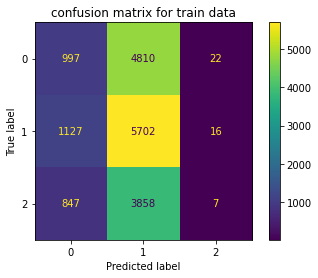

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(sentiment_train, predict_train)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0', '1','2'])
cm_display.plot()
plt.title('confusion matrix for train data')

plt.show()




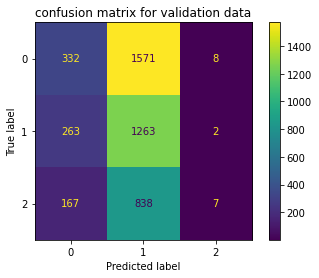

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(sentiment_val, predict_val)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0', '1','2'])
cm_display.plot()
plt.title('confusion matrix for validation data')

plt.show()




now in second method, we choose three images (with highest confidence level) if number of faces are lower that 3, we repeat highest confidence image.

In [ ]:
number_arr = np.asarray(number_list)
confidence_arr = np.asarray(confidence_list)
unique_num = np.unique(number_arr)
sentiment_train = np.zeros((len(unique_num),))
prob_train_chosen = np.zeros((len(unique_num),3*3))
counter = 0
for index in unique_num:
  prob_score = np.asarray(confidence_arr[index == number_arr])
  chosen_index_prob = np.zeros((3,))
  index_sorted = np.flip(np.argsort(prob_score))
  chosen_index_prob[0:np.min((3,len(prob_score)))] = index_sorted[0:np.min((3,len(prob_score)))]
  if len(prob_score) == 1:
    chosen_index_prob[1] = index_sorted[0]
    chosen_index_prob[2] = index_sorted[0]
  if len(prob_score) == 2:
    chosen_index_prob[2] = index_sorted[0]

  chosen_index = np.where(index == number_arr)[0]
  chosen_index = chosen_index[0]
  prob = out_logits_train[index == number_arr,:]
  for j in range(3):
    prob_train_chosen[counter,j*3:3 + j*3] = prob[int(chosen_index_prob[j]),:]

  sentiment_train[counter] = sentiment_list[chosen_index]
  counter = counter + 1
  

In [ ]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=10000).fit(prob_train_chosen, sentiment_train)
sentiment_train_p = rbf.predict(prob_train_chosen)
acc = np.sum(sentiment_train_p == sentiment_train)/len(sentiment_train_p)
print(f"svm based model accuracy = {acc}")

svm based model accuracy = 0.41107787875301965


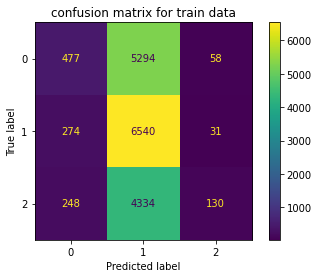

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(sentiment_train, sentiment_train_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0', '1','2'])
cm_display.plot()
plt.title('confusion matrix for train data')

plt.show()



In [ ]:
number_arr = np.asarray(number_list_v)
confidence_arr = np.asarray(confidence_list_v)
unique_num = np.unique(number_arr)
sentiment_val = np.zeros((len(unique_num),))
prob_val_chosen = np.zeros((len(unique_num),3*3))
counter = 0
for index in unique_num:
  prob_score = np.asarray(confidence_arr[index == number_arr])
  chosen_index_prob = np.zeros((3,))
  index_sorted = np.flip(np.argsort(prob_score))
  chosen_index_prob[0:np.min((3,len(prob_score)))] = index_sorted[0:np.min((3,len(prob_score)))]
  if len(prob_score) == 1:
    chosen_index_prob[1] = index_sorted[0]
    chosen_index_prob[2] = index_sorted[0]
  if len(prob_score) == 2:
    chosen_index_prob[2] = index_sorted[0]

  chosen_index = np.where(index == number_arr)[0]
  chosen_index = chosen_index[0]
  prob = out_logits_val[index == number_arr,:]
  for j in range(3):
    prob_val_chosen[counter,j*3:3 + j*3] = prob[int(chosen_index_prob[j]),:]

  sentiment_val[counter] = sentiment_list[chosen_index]
  counter = counter + 1
  

In [ ]:
sentiment_val_p = rbf.predict(prob_val_chosen)
acc = np.sum(sentiment_val_p == sentiment_val)/len(sentiment_val_p)
print(f"svm based model accuracy for validation = {acc}")

svm based model accuracy for validation = 0.35160638058863175


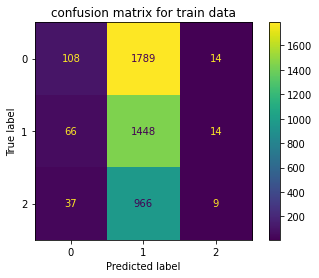

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(sentiment_val, sentiment_val_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0', '1','2'])
cm_display.plot()
plt.title('confusion matrix for train data')

plt.show()



# Prime augmentation

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math

import torch
from einops import parse_shape, rearrange
from opt_einsum import contract


class RandomSmoothColor(torch.nn.Module):
    def __init__(self, cut, T, freq_bandwidth=None, stochastic=False, T_min=0.):
        super().__init__()
        self.cut = cut
        self.T = T
        self.freq_bandwidth = freq_bandwidth
        
        self.stochastic = stochastic
        if self.stochastic:
            self.cut_max = cut
            self.T_min = T_min
            self.T_max = T

    def forward(self, img):

        if self.stochastic:
            self._sample_params()

        init_shape = img.shape
        if len(init_shape) < 4:
            img = rearrange(img, "c h w -> () c h w")

        return self.random_smooth_color(img, self.cut, self.T, self.freq_bandwidth).reshape(init_shape)

    def _sample_params(self):
        self.cut = torch.randint(low=1, high=self.cut_max + 1, size=(1,)).item()
        self.T = torch.FloatTensor([1]).uniform_(self.T_min, self.T_max).item()

    def random_smooth_color(self, img, cut, T, freq_bandwidth=None):
        img_shape = parse_shape(img, "b c h w")
        colors = rearrange(img, "b c h w -> b c (h w)")

        if freq_bandwidth is not None:
            min_k = torch.randint(low=1, high=cut + 1, size=(1,)).item()
            k = torch.arange(
                min_k, min(min_k + freq_bandwidth, cut + 1), 
                device=img.device
            )
            coeff = torch.randn(
                (img_shape["b"], img_shape["c"], k.shape[0]), 
                device=img.device
            )
        else:
            coeff = torch.randn(
                (img_shape["b"], img_shape["c"], cut), 
                device=img.device
            )
            k = torch.arange(1, cut + 1, device=img.device)

        coeff = coeff * torch.sqrt(torch.tensor(T))

        freqs = torch.sin(colors[..., None] * k[None, None, None, :] * math.pi)

        # transformed_colors = torch.einsum("bcf,bcnf->bcn", coeff, freqs) + colors
        transformed_colors = contract("bcf, bcnf -> bcn", coeff, freqs) + colors
        transformed_colors = torch.clamp(transformed_colors, 0, 1)

        transformed_image = rearrange(transformed_colors, " b c (h w) -> b c h w", **img_shape)
        return transformed_image

    def __repr__(self):
        return self.__class__.__name__ + f"(T={self.T}, cut={self.cut})"

random_color = RandomSmoothColor(5, 0.02)


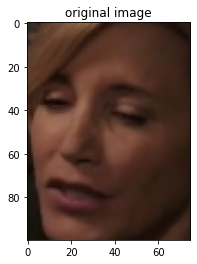

In [ ]:
random_color = RandomSmoothColor(5, 0.02)
batch_size = 64
transformation= transforms.Compose([transforms.ToTensor()])
train_dataset_face= Face_Dataset(face = faces_list ,labels = sentiment_list,  transform = transformation)
val_dataset_face = Face_Dataset(face = faces_list_v ,labels = sentiment_list_v,  transform = transformation)
train_loader_face= DataLoader(train_dataset_face,batch_size=batch_size,shuffle = True,)
val_loader_face=   DataLoader(val_dataset_face,batch_size=batch_size,shuffle = False)
a ,_ = train_dataset_face[2]
plt.imshow(  a.permute(1, 2, 0)  )
plt.title('original image')
a2 = random_color(a)


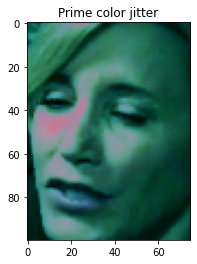

In [ ]:
plt.title('Prime color jitter')
plt.imshow(  a2.permute(1, 2, 0)  )


In [ ]:
import functools
import math
import torch
from einops import rearrange
from opt_einsum import contract


class Diffeo(torch.nn.Module):
    """Randomly apply a diffeomorphism to the image(s).
    The image should be a Tensor and it is expected to have [..., n, n] shape,
    where ... means an arbitrary number of leading dimensions.
    A random cut is drawn from a discrete Beta distribution of parameters
    alpha and beta such that
        s = alpha + beta (measures how peaked the distribution is)
        r = alpha / beta (measured how biased towards cutmax the distribution is)
    Given cut and the allowed* interval of temperatures [Tmin, Tmax], a random T is
    drawn from a Beta distribution with parameters alpha and beta such that:
        s = alpha + beta (measures how peaked the distribution is)
        r = alpha / beta (measured how biased towards T_max the distribution is)
    Beta ~ delta_function for s -> inf. To apply a specific value x \in [0, 1]
    in the allowed interval of T or cut, set
        - s = 1e10
        - r = x / (1 - x)
    *the allowed T interval is defined such as:
        - Tmin corresponds to a typical displacement of 1/2 pixel in the center
          of the image
        - Tmax corresponds to the highest T for which no overhangs are present.
    Args:
        sT (float):
        rT (float):
        scut (float):
        rcut (float):
        cut_min (int):
        cut_max (int):
    Returns:
        Tensor: Diffeo version of the input image(s).
    """

    def __init__(self, sT, rT, scut, rcut, cutmin, cutmax, alpha, stochastic=False):
        super().__init__()

        self.sT = sT
        self.rT = rT
        self.scut = scut
        self.rcut = rcut
        self.cutmin = cutmin
        self.cutmax = cutmax
        self.alpha = alpha

        self.stochastic = stochastic
        if self.stochastic:
            self.cutmax_max = cutmax
            self.alpha_max = alpha

        self.betaT = torch.distributions.beta.Beta(sT - sT / (rT + 1), sT / (rT + 1), validate_args=None)
        self.betacut = torch.distributions.beta.Beta(scut - scut / (rcut + 1), scut / (rcut + 1), validate_args=None)

    def forward(self, img):
        """
        Args:
            img (Tensor): Image(s) to be 'diffeomorphed'.
        Returns:
            Tensor: Diffeo image(s).
        """

        init_shape = img.shape
        if len(init_shape) < 4:
            img = rearrange(img, "c h w -> () c h w")

        if self.stochastic:
            self._sample_params()

        # image size
        n = img.shape[-1]

        cut = (self.betacut.sample() * (self.cutmax + 1 - self.cutmin) + self.cutmin).int().item()
        T1, T2 = temperature_range(n, cut)
        T2 = max(T1, self.alpha * T2)
        T = (self.betaT.sample() * (T2 - T1) + T1)

        return deform(img, T, cut).reshape(init_shape)

    def _sample_params(self):
        self.cutmax = torch.randint(low=self.cutmin + 1, high=self.cutmax_max + 1, size=(1,)).item()
        # self.alpha = torch.FloatTensor([1]).uniform_(0., self.alpha_max).item()

    def __repr__(self):
        return self.__class__.__name__ + f'(sT={self.sT}, rT={self.rT}, scut={self.scut}, rcut={self.rcut}, cutmin={self.cutmin}, cutmax={self.cutmax})'



@functools.lru_cache()
def scalar_field_modes(n, m, dtype=torch.float64, device='cpu'):
    """
    sqrt(1 / Energy per mode) and the modes
    """
    x = torch.linspace(0, 1, n, dtype=dtype, device=device)
    k = torch.arange(1, m + 1, dtype=dtype, device=device)
    i, j = torch.meshgrid(k, k)
    r = (i.pow(2) + j.pow(2)).sqrt()
    e = (r < m + 0.5) / r
    s = torch.sin(math.pi * x[:, None] * k[None, :])
    return e, s


def scalar_field(n, m, device='cpu'):
    """
    random scalar field of size nxn made of the first m modes
    """
    e, s = scalar_field_modes(n, m, dtype=torch.get_default_dtype(), device=device)
    c = torch.randn(m, m, device=device) * e
    # return torch.einsum('ij,xi,yj->yx', c, s, s)
    return contract('ij,xi,yj->yx', c, s, s)


def deform(image, T, cut, interp='linear'):
    """
    1. Sample a displacement field tau: R2 -> R2, using tempertature `T` and cutoff `cut`
    2. Apply tau to `image`
    :param img Tensor: square image(s) [..., y, x]
    :param T float: temperature
    :param cut int: high frequency cutoff
    """
    n = image.shape[-1]
    assert image.shape[-2] == n, 'Image(s) should be square.'

    device = image.device

    # Sample dx, dy
    # u, v are defined in [0, 1]^2
    # dx, dx are defined in [0, n]^2
    u = scalar_field(n, cut, device)  # [n,n]
    v = scalar_field(n, cut, device)  # [n,n]
    dx = T ** 0.5 * u * n
    dy = T ** 0.5 * v * n

    # Apply tau
    return remap(image, dx, dy, interp)


def remap(a, dx, dy, interp):
    """
    :param a: Tensor of shape [..., y, x]
    :param dx: Tensor of shape [y, x]
    :param dy: Tensor of shape [y, x]
    :param interp: interpolation method
    """
    n, m = a.shape[-2:]
    assert dx.shape == (n, m) and dy.shape == (n, m), 'Image(s) and displacement fields shapes should match.'

    y, x = torch.meshgrid(torch.arange(n, dtype=dx.dtype, device=a.device), torch.arange(m, dtype=dx.dtype, device=a.device))

    xn = (x - dx).clamp(0, m-1)
    yn = (y - dy).clamp(0, n-1)

    if interp == 'linear':
        xf = xn.floor().long()
        yf = yn.floor().long()
        xc = xn.ceil().long()
        yc = yn.ceil().long()

        xv = xn - xf
        yv = yn - yf

        return (1-yv)*(1-xv)*a[..., yf, xf] + (1-yv)*xv*a[..., yf, xc] + yv*(1-xv)*a[..., yc, xf] + yv*xv*a[..., yc, xc]

    if interp == 'gaussian':
        # can be implemented more efficiently by adding a cutoff to the Gaussian
        sigma = 0.4715

        dx = (xn[:, :, None, None] - x)
        dy = (yn[:, :, None, None] - y)

        c = (-dx**2 - dy**2).div(2 * sigma**2).exp()
        c = c / c.sum([2, 3], keepdim=True)

        return (c * a[..., None, None, :, :]).sum([-1, -2])


def temperature_range(n, cut):
    """
    Define the range of allowed temperature
    for given image size and cut.
    """
    if cut == 0:
        print("Cut is zero!")
    if isinstance(cut, (float, int)):
        cut = cut + 1e-6
        log = math.log(cut)
    else:
        log = cut.log()
    T1 = 1 / (math.pi * n ** 2 * log)
    T2 = 4 / (math.pi ** 3 * cut ** 2 * log)
    return T1, T2


def typical_displacement(T, cut, n):
    if isinstance(cut, (float, int)):
        log = math.log(cut)
    else:
        log = cut.log()
    return n * (math.pi * T * log) ** .5 / 2
sT = 1.
rT = 1.
scut = 1.
rcut = 1.
cutmin = 25
cutmax = 60
alpha = 3.0
Diffeo_img = Diffeo(sT, rT, scut, rcut, cutmin, cutmax, alpha, stochastic=False)

In [ ]:
transformation= transforms.Compose([transforms.ToTensor(),transforms.Resize(size = (75,75))])
train_dataset_face= Face_Dataset(face = faces_list ,labels = sentiment_list,  transform = transformation)
val_dataset_face = Face_Dataset(face = faces_list_v ,labels = sentiment_list_v,  transform = transformation)
train_loader_face= DataLoader(train_dataset_face,batch_size=batch_size,shuffle = True,)
val_loader_face=   DataLoader(val_dataset_face,batch_size=batch_size,shuffle = False)
a ,_ = train_dataset_face[2]


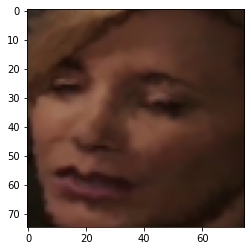

In [ ]:
a2 = Diffeo_img(a)
plt.imshow(  a2.permute(1, 2, 0)  )


In [ ]:
import numpy as np
import torch
from einops import parse_shape, rearrange


class RandomFilter(torch.nn.Module):
    def __init__(self, kernel_size, sigma, stochastic=False, sigma_min=0.):
        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma

        self.stochastic = stochastic
        if self.stochastic:
            self.kernels_size_candidates = torch.tensor([float(i) for i in range(self.kernel_size, self.kernel_size + 2, 2)])
            self.sigma_min = sigma_min
            self.sigma_max = sigma

    def forward(self, img):
        if self.stochastic:
            self._sample_params()

        init_shape = img.shape
        if len(init_shape) < 4:
            img = rearrange(img, "c h w -> () c h w")

        shape_dict = parse_shape(img, "b c h w")
        batch_size = shape_dict["b"]
        img = rearrange(img, "b c h w -> c b h w")

        delta = torch.zeros((1, self.kernel_size, self.kernel_size), device=img.device)
        center = int(np.ceil(self.kernel_size / 2))
        delta[0, center, center] = 1.0

        conv_weight = rearrange(
            self.sigma * torch.randn((batch_size, self.kernel_size, self.kernel_size), device=img.device) + delta,
            "b h w -> b (h w)",
        )

        conv_weight = rearrange(conv_weight, "b (h w) -> b () h w", h=self.kernel_size)

        filtered_img = torch.nn.functional.conv2d(
            img, conv_weight, padding="same", groups=batch_size
        )

        # Deal with NaN values due to mixed precision -> Convert them to 1.
        filtered_img[filtered_img.isnan()] = 1.

        filtered_img = rearrange(filtered_img, "c b h w -> b c h w")
        filtered_img = torch.clamp(filtered_img, 0., 1.).reshape(init_shape)

        return filtered_img

    def _sample_params(self):
        self.kernel_size = int(self.kernels_size_candidates[torch.multinomial(self.kernels_size_candidates, 1)].item())
        self.sigma = torch.FloatTensor([1]).uniform_(self.sigma_min, self.sigma_max).item()

    def __repr__(self):
        return self.__class__.__name__ + f"(sigma={self.sigma}, kernel_size={self.kernel_size})"


random_filter = RandomFilter(3, 0.5)


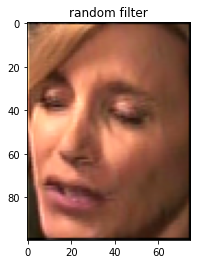

In [ ]:
a2 = random_filter.forward(a)

plt.title('random filter')
plt.imshow(  a2.permute(1, 2, 0)  )


In [ ]:
import torch

from torch.distributions import Dirichlet, Beta
from einops import rearrange, repeat
from opt_einsum import contract


class PRIMEAugModule(torch.nn.Module):
    def __init__(self, augmentations):
        super().__init__()
        self.augmentations = augmentations
        self.num_transforms = len(augmentations)

    def forward(self, x, mask_t):
        aug_x = torch.zeros_like(x)
        for i in range(self.num_transforms):
            aug_x += self.augmentations[i](x) * mask_t[:, i]
        return aug_x

class GeneralizedPRIMEModule(torch.nn.Module):
    def __init__(
        self, preprocess, aug_module, mixture_width=3, 
        mixture_depth=-1, no_jsd=False, max_depth=3
    ):
        """
        Wrapper to perform PRIME augmentation.
        :param preprocess: Preprocessing function which should return a torch tensor
        :param all_ops: Weather to use all augmentation operations (including the forbidden ones such as brightness)
        :param mixture_width: Number of augmentation chains to mix per augmented example
        :param mixture_depth: Depth of augmentation chains. -1 denotes stochastic depth in [1, 3]
        :param no_jsd: Turn off JSD consistency loss
        """
        super().__init__()
        self.preprocess = preprocess
        self.aug_module = aug_module
        self.mixture_width = mixture_width
        self.mixture_depth = mixture_depth
        self.no_jsd = no_jsd

        self.max_depth = max_depth
        self.depth = self.mixture_depth if self.mixture_depth > 0 else self.max_depth
        self.depth_combos = torch.tril(torch.ones((max_depth, max_depth)))

    @torch.no_grad()
    def forward(self, img):
        if self.no_jsd:
            return self.aug(img)
        else:
            return torch.cat((self.preprocess(img), self.aug(img),
                              self.aug(img)), 0)

    
    def aug(self, img):
        self.dirichlet = Dirichlet(concentration=torch.tensor([1.] * self.mixture_width, device=img.device))
        self.beta = Beta(concentration1=torch.ones(1, device=img.device, dtype=torch.float32), concentration0=torch.ones(1, device=img.device, dtype=torch.float32))

        ws = self.dirichlet.sample([img.shape[0]])
        m = self.beta.sample([img.shape[0]])[..., None, None]

        img_repeat = repeat(img, 'b c h w -> m b c h w', m=self.mixture_width)
        img_repeat = rearrange(img_repeat, 'm b c h w -> (m b) c h w')

        trans_combos = torch.eye(self.aug_module.num_transforms, device=img_repeat.device)
        depth_mask = torch.zeros(img_repeat.shape[0], self.max_depth, 1, 1, 1, device=img_repeat.device)
        trans_mask = torch.zeros(img_repeat.shape[0], self.aug_module.num_transforms, 1, 1, 1, device=img_repeat.device)

        depth_idx = torch.randint(0, len(self.depth_combos), size=(img_repeat.shape[0],))
        depth_mask.data[:, :, 0, 0, 0] = self.depth_combos[depth_idx]

        image_aug = img_repeat.clone()

        for d in range(self.depth):

            trans_idx = torch.randint(0, len(trans_combos), size=(img_repeat.shape[0],))
            trans_mask.data[:, :, 0, 0, 0] = trans_combos[trans_idx]

            image_aug.data = depth_mask[:, d] * self.aug_module(image_aug, trans_mask) + (1. - depth_mask[:, d]) * image_aug

        image_aug = rearrange(self.preprocess(image_aug), '(m b) c h w -> m b c h w', m=self.mixture_width)

        mix = torch.einsum('bm, mbchw -> bchw', ws, image_aug)
        mixed = (1. - m) * self.preprocess(img) + m * mix

        return mixed

for testing previous model, because input shape is not square we don't use deformation transformation but in second part where we train model again, we first resizs image to (75 * 75 ) and then train network

In [ ]:
import torch
import torch.nn as nn




class TransformLayer(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        mean = torch.as_tensor(mean, dtype=torch.float)[None, :, None, None]
        std = torch.as_tensor(std, dtype=torch.float)[None, :, None, None]
        self.mean = nn.Parameter(mean, requires_grad=False)
        self.std = nn.Parameter(std, requires_grad=False)

    def forward(self, x):
        return x.sub(self.mean).div(self.std)

    
class AugModel(nn.Module):
    def __init__(self, model, aug):
        super().__init__()
        self.model = model
        self.aug = aug
        self.use_augmentation = False

    def enable_augmentation(self, val):
        self.use_augmentation = val

    def forward(self, x):
        if self.model.training:
            return self.model(self.aug(x))
        return self.model(x)


def deactivate_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()


def deactivate_batchnorm_bias(m):
    if isinstance(m, nn.BatchNorm2d):
        m.bias.requires_grad_(False)
        m.running_mean.zero_()
        with torch.no_grad():
            m.bias.requires_grad_(False)

In [ ]:
augmentations = []
augmentations.append(random_filter)
augmentations.append(random_color)
mixture_width = 3
mixture_depth = -1
no_jsd = False
severity = 3

now we got our augmentation module ready, input it takes batch of images and output it gives preprocessed image (normalized, ...) and two augmentad images based on method described in paper.
but as we said, because inputs are not in square format for evaluation we don't use deformation transform

In [ ]:
prime_module = GeneralizedPRIMEModule(
          preprocess=TransformLayer((0.5,), (0.5,)), # normalization based on imagenet distribution
          mixture_width=mixture_width,
          mixture_depth=mixture_depth,
          no_jsd=no_jsd, max_depth=3,
          aug_module=PRIMEAugModule(augmentations),
      )

In [ ]:
model_resnet_trained = torchvision.models.resnet50(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet_trained.fc.in_features
model_resnet_trained.fc = nn.Linear(num_ftrs, 3) # we have 10 output class

model_resnet_trained = model_resnet_trained.to(device)
if device == 'cpu':
  model_resnet_trained.load_state_dict(torch.load('/content/gdrive/MyDrive/Phase_1_models/resnet_trained',map_location=torch.device('cpu')))
else:
  model_resnet_trained.load_state_dict(torch.load('/content/gdrive/MyDrive/Phase_1_models/resnet_trained'))
model_resnet_trained.eval()



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_dataset_face= Face_Dataset(face = faces_list ,labels = sentiment_list,  transform = transformation)
val_dataset_face = Face_Dataset(face = faces_list_v ,labels = sentiment_list_v,  transform = transformation)
train_loader_face= DataLoader(train_dataset_face,batch_size=batch_size,shuffle = True,)
val_loader_face=   DataLoader(val_dataset_face,batch_size=batch_size,shuffle = False)

In [ ]:
acc = 0
for i in range(len(train_dataset_face)):
  img = img.to(device)
  img,label = train_dataset_face[i]
  img = img.unsqueeze(0)
  prime_aug = prime_module(img)
  predicted = model_resnet_trained(prime_aug)
  _, preds = torch.max(predicted, 1)
  acc += torch.sum(preds == label)
acc = acc/(3*len(train_dataset_face))
print(f"accuracy on augmented data{acc}")


accuracy on augmented data0.34472963213920593


In [ ]:
acc = 0
for i in range(len(val_dataset_face)):
  img = img.to(device)
  img,label = val_dataset_face[i]
  img = img.unsqueeze(0)
  prime_aug = prime_module(img)
  predicted = model_resnet_trained(prime_aug)
  _, preds = torch.max(predicted, 1)
  acc += torch.sum(preds == label)
acc = acc/(3*len(val_dataset_face))
print(f"accuracy on augmented data for validation{acc}")


accuracy on augmented data for validation0.37813594937324524


usually its meaningless to apply augmentation to validation data and compare results,

In [ ]:
import itertools
def repeat_list(label,repeat_num = 3):
  """
  function for repeating label
  inputs:
    label: input labels
    repeat_num: number of repeat of each element

  """
  out = list(itertools.chain(*(itertools.repeat(elem, repeat_num) for elem in label)))
  
  return out



In [ ]:
augmentations = []
augmentations.append(random_filter)
augmentations.append(random_color)
augmentations.append(Diffeo_img)

mixture_width = 3
mixture_depth = -1
no_jsd = False
severity = 3
prime_module = GeneralizedPRIMEModule(
          preprocess=TransformLayer((0.5,), (0.5,)), # normalization based on imagenet distribution
          mixture_width=mixture_width,
          mixture_depth=mixture_depth,
          no_jsd=no_jsd, max_depth=3,
          aug_module=PRIMEAugModule(augmentations),
      )

In [ ]:
transformation= transforms.Compose([transforms.ToTensor(),transforms.Resize(size = (75,75)),transforms.Normalize((0.5,), (0.5,))])
train_dataset_face= Face_Dataset(face = faces_list ,labels = sentiment_list,  transform = transformation)
val_dataset_face = Face_Dataset(face = faces_list_v ,labels = sentiment_list_v,  transform = transformation)
train_loader_face= DataLoader(train_dataset_face,batch_size=16,shuffle = True,)
val_loader_face=   DataLoader(val_dataset_face,batch_size=batch_size,shuffle = False)

In [ ]:
prime_module = prime_module.to(device)
for img,label in train_loader_face:
  img = img.to(device)
  label = label.to(device)
  img_mod = prime_module(img)
  img_mod = img_mod.to(device)
  img_label = model_resnet_trained(img_mod)
  label_r = repeat_list(label)
  label = torch.tensor(label_r)
  
  break

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
def train_model_manual_aug(model, criterion, optimizer,scheduler,val_beark,data_loader_train,data_loader_val,len_train,len_val, num_epochs=25):
  """
  function for train our model! in this function we use dataloader directly. so we only can use it for our CIFAR10 dataset with our input name. compared to previous function, 
  we use augmented dataset here
  inputs: 
      model: input model 
      criterion: desired loss function
      optimizer: our optimizer(!)
      scheduler: for changing learning rate after sum epochs
      num_epochs: number of epoches
      val_beark: threshold for early stopping, if after "val_beark" steps our model don't get better, we end procces
  output:
      model: our trained model!


  """
  train_acc = []
  train_loss = []
  test_acc = []
  test_loss = []
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 100000000000
  counter_val_beark = 0
  for epoch in range(num_epochs):
    ### Training
    model.train()
    loss_train = 0
    acc_train = 0
    counter = 1
    for batch,label in tqdm(data_loader_train, total=len(data_loader_train), desc="training... "):
      # 1. Forward pass
      batch = batch.to(device)
      label = label.to(device)
      img_mod = prime_module(batch)
      img_mod = img_mod.to(device)
      #label_r = repeat_list(label)
      label = label.repeat(3)
      label = label.to(device)
      outputs = model(img_mod) # model outputs raw logits 
      _, preds = torch.max(outputs, 1)

      # print(y_logits)
      # 2. Calculate loss and accuracy
      counter = counter + 1
      loss = criterion(outputs, label)
      acc_train += torch.sum(preds == label.data)
      loss_train = loss_train + loss
      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()
    loss_train = loss_train/(3*len_train)
    acc_train = acc_train/(3*len_train)
    train_acc.append(acc_train)
    train_loss.append(loss_train)
    scheduler.step()
    ### Testing
    loss_test = 0
    acc_test = 0
    counter = 1
    model.eval()
    with torch.inference_mode():
      for batch,label in tqdm(data_loader_val, total=len(data_loader_val), desc="Validating... "):
      # 1. Forward pass
        batch = batch.to(device)
        label = label.to(device)
        output = model(batch) # model outputs raw logits 
        _, preds = torch.max(output, 1)
        loss_test= criterion(output, label.data)
        acc_test += torch.sum(preds == label.data)
      loss_test = loss_test/len_val
      acc_test = acc_test/len_val
      test_loss.append(loss_test)
      test_acc.append(acc_test)
    if acc_test > best_acc:
                best_acc = acc_test
                best_model_wts = copy.deepcopy(model.state_dict())
    if loss_test <= best_loss:
                best_loss = loss_test
                counter_val_beark = 0
    if loss_test > best_loss:
                counter_val_beark = counter_val_beark + 1
                if (counter_val_beark > val_beark):
                  print(f"early stopping happend!")
                  break;

    # Print out what's happening
    if epoch % 1 == 0:
      print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {acc_test:.2f}%") 
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model,best_loss,best_acc


In [ ]:
model_resnet = torchvision.models.resnet50(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 3) # we have 10 output class

model_resnet = model_resnet.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
model_resnet = model_resnet.to(device)
prime_module = prime_module.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_resnet.parameters(), lr=0.005)
# Decay LR by a factor of 0.5 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=100, gamma=0.5)

model_resnet = model_resnet.to(device)
model_resnet_trained,best_loss,best_acc = train_model_manual_aug(model_resnet, criterion, optimizer_conv,exp_lr_scheduler,20,train_loader_face,val_loader_face,len(train_dataset_face),len(val_dataset_face),num_epochs=7)

Validating... : 100%|██████████| 106/106 [00:03<00:00, 29.28it/s]


Epoch: 0 | Loss: 0.02308, Acc: 0.37% | Test Loss: 0.00050, Test Acc: 0.38%


Validating... : 100%|██████████| 106/106 [00:03<00:00, 30.38it/s]


Epoch: 1 | Loss: 0.02276, Acc: 0.37% | Test Loss: 0.00016, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:03<00:00, 30.89it/s]


Epoch: 2 | Loss: 0.02276, Acc: 0.37% | Test Loss: 0.00017, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:03<00:00, 30.37it/s]


Epoch: 3 | Loss: 0.02280, Acc: 0.37% | Test Loss: 0.00017, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:03<00:00, 30.64it/s]


Epoch: 4 | Loss: 0.02275, Acc: 0.38% | Test Loss: 0.00017, Test Acc: 0.37%


Validating... : 100%|██████████| 106/106 [00:03<00:00, 30.53it/s]


Epoch: 5 | Loss: 0.02275, Acc: 0.37% | Test Loss: 0.00017, Test Acc: 0.35%


Validating... : 100%|██████████| 106/106 [00:03<00:00, 29.82it/s]


Epoch: 6 | Loss: 0.02275, Acc: 0.38% | Test Loss: 0.00016, Test Acc: 0.35%
Training complete in 47m 28s
Best val Acc: 0.377791


In [ ]:
torch.save(model_resnet_trained.state_dict(), '/content/gdrive/MyDrive/Phase_1_models/resnet_trained_aug')

In [ ]:
model_resnet_trained_aug = torchvision.models.resnet50(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet_trained_aug.fc.in_features
model_resnet_trained_aug.fc = nn.Linear(num_ftrs, 3) # we have 10 output class

model_resnet_trained_aug = model_resnet_trained_aug.to(device)
if device == 'cpu':
  model_resnet_trained_aug.load_state_dict(torch.load('/content/gdrive/MyDrive/Phase_1_models/resnet_trained_aug',map_location=torch.device('cpu')))
else:
  model_resnet_trained_aug.load_state_dict(torch.load('/content/gdrive/MyDrive/Phase_1_models/resnet_trained_aug'))




In [ ]:
transformation= transforms.Compose([transforms.ToTensor(),transforms.Resize(size = (75,75)),transforms.Normalize((0.5,), (0.5,))])
test_dataset_face = Face_Dataset(face = faces_list_t ,labels = sentiment_list_t,  transform = transformation)
test_loader_face= DataLoader(test_dataset_face,batch_size=64,shuffle = True,)

In [ ]:
model_resnet_trained_aug.eval()
acc_test = 0
with torch.inference_mode():
  for batch,label in tqdm(test_loader_face, total=len(test_loader_face), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_resnet_trained_aug(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    acc_test += torch.sum(preds == label.data)
print(f'accuracy on test data = {acc_test/len(test_dataset_face)}')

Testing... : 100%|██████████| 108/108 [00:05<00:00, 18.04it/s]

accuracy on test data = 0.4213499426841736
